In [2]:
### Load Modules
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
from matplotlib.image import NonUniformImage

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import neurokit2 as nk
import biosppy
import pyhrv.tools as tools

In [3]:
### Read Dataset
path = './data/OSASUD.pickle'
with open(path, 'rb') as file:
    df = pickle.load(file)
    
display(df.head())

,patient,timestamp_datetime,HR(bpm),SpO2(%),PI(%),RR(rpm),PVCs(/min),event,anomaly,signal_pleth,signal_ecg_i,signal_ecg_ii,signal_ecg_iii,PSG_Abdomen,PSG_Flow,PSG_Position,PSG_Snore,PSG_Thorax
0,1,2019-07-29 21:00:36,63.0,NaN,NaN,12.0,0.0,NONE,False,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[122, 121, 121, 120, 121, 123, 124, 125, 125, ...","[122, 121, 121, 120, 120, 122, 123, 124, 125, ...","[128, 128, 129, 128, 127, 127, 127, 128, 128, ...","[-0.8741500623767957, -0.9144675352463544, -0....","[-2.96563402995406, -2.9595796764374294, -2.95...","[-0.47401902530550133, -0.4739045513646679, -0...","[0.07924500093530636, 0.03509163903208667, 0.1...","[-0.3731332842321416, -0.3840816526328088, -0...."
1,1,2019-07-29 21:00:37,63.0,NaN,NaN,12.0,0.0,NONE,False,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[124, 125, 125, 124, 124, 124, 124, 124, 124, ...","[123, 124, 123, 123, 123, 122, 123, 123, 123, ...","[127, 127, 127, 127, 127, 126, 127, 128, 127, ...","[-0.9881929400632088, -0.9477638031010281, -0....","[-1.361721983810798, -0.5937676928280333, 0.10...","[-0.47401917910760316, -0.4739043984870266, -0...","[0.1730628474409785, 0.05274774088651335, 0.07...","[-0.3271092235750278, -0.34422787330023297, -0..."
2,1,2019-07-29 21:00:38,64.0,NaN,NaN,12.0,0.0,NONE,False,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[124, 124, 124, 124, 123, 124, 124, 124, 124, ...","[123, 124, 124, 124, 124, 124, 124, 124, 124, ...","[127, 128, 128, 128, 129, 128, 128, 128, 128, ...","[0.08614440036034249, 0.2516121296765992, 0.42...","[1.106683267015266, 1.0603761242579164, 1.0141...","[-0.4740193239619996, -0.47390425449218476, -0...","[0.17804040728101125, 0.11939900653197982, 0.1...","[-0.12950805941595078, -0.11899340882221601, -..."
3,1,2019-07-29 21:00:39,64.0,NaN,NaN,12.0,0.0,NONE,False,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[124, 124, 124, 124, 123, 124, 123, 123, 124, ...","[126, 126, 126, 126, 126, 125, 126, 126, 126, ...","[130, 130, 130, 130, 131, 129, 131, 131, 131, ...","[1.1531959630520392, 1.1005866213221034, 1.014...","[-0.9214725025271104, -0.9771933825390473, -1....","[-0.4740194604923075, -0.4739041187620709, -0....","[0.04909074879934492, 0.1211243456818879, 0.20...","[0.014197466691675964, 0.05145753481049522, 0...."
4,1,2019-07-29 21:00:40,64.0,NaN,NaN,12.0,0.0,NONE,False,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[123, 124, 125, 124, 124, 124, 124, 124, 124, ...","[128, 127, 126, 125, 126, 127, 126, 125, 125, ...","[133, 131, 129, 129, 130, 131, 130, 130, 129, ...","[-0.42549812754662325, -0.5447443993201948, -0...","[-1.035218708573095, -1.0000002320633845, -0.9...","[-0.47401958926922777, -0.47390399073098, -0.4...","[0.020529048615559067, 0.5111613725192, 0.0863...","[-0.004534125269965855, -0.04243555140344553, ..."


In [6]:
### EDA on non-objects
print('Rows:', df.shape[0])
print('Columns:', df.shape[1])

display(df.dtypes)

print('Groups - Unique Patient IDs: ', df.patient.unique())
print("Number of distinct patients:", len(df['patient'].unique()))

print('Target - Unique Apnea Events (Target): ', df.event.unique())
print("Number of apnea types:", len(df.event.unique()))

Rows: 961357
Columns: 18


patient                       object
timestamp_datetime    datetime64[ns]
HR(bpm)                      float64
SpO2(%)                      float64
PI(%)                        float64
RR(rpm)                      float64
PVCs(/min)                   float64
event                         object
anomaly                      boolean
signal_pleth                  object
signal_ecg_i                  object
signal_ecg_ii                 object
signal_ecg_iii                object
PSG_Abdomen                   object
PSG_Flow                      object
PSG_Position                  object
PSG_Snore                     object
PSG_Thorax                    object
dtype: object

Groups - Unique Patient IDs:  ['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '2' '19' '20' '21' '22'
 '23' '24' '25' '26' '3' '27' '28' '29' '30' '4' '5' '6' '7' '8' '9']
Number of distinct patients: 30
Target - Unique Apnea Events (Target):  ['NONE' 'HYPOPNEA' 'APNEA-CENTRAL' 'APNEA-OBSTRUCTIVE' 'APNEA-MIXED']
Number of apnea types: 5


In [7]:
### Describe Numerical features
display(df.describe())

,HR(bpm),SpO2(%),PI(%),RR(rpm),PVCs(/min)
count,957813.000000,828777.000000,828102.000000,942901.000000,957813.000000
mean,64.683292,95.479754,3.981212,15.894219,0.629161
std,14.302865,2.875233,2.416226,3.689678,2.308404
min,30.000000,60.000000,0.060000,5.000000,0.000000
25%,54.000000,94.000000,2.200000,13.000000,0.000000
50%,62.000000,96.000000,3.510000,15.000000,0.000000
75%,74.000000,97.000000,5.270000,18.000000,0.000000
max,168.000000,100.000000,20.000000,36.000000,123.000000


C:\Users\petru\AppData\Local\Temp\ipykernel_19696\3843752447.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(k) for k in current_values])


<function matplotlib.pyplot.show(close=None, block=None)>

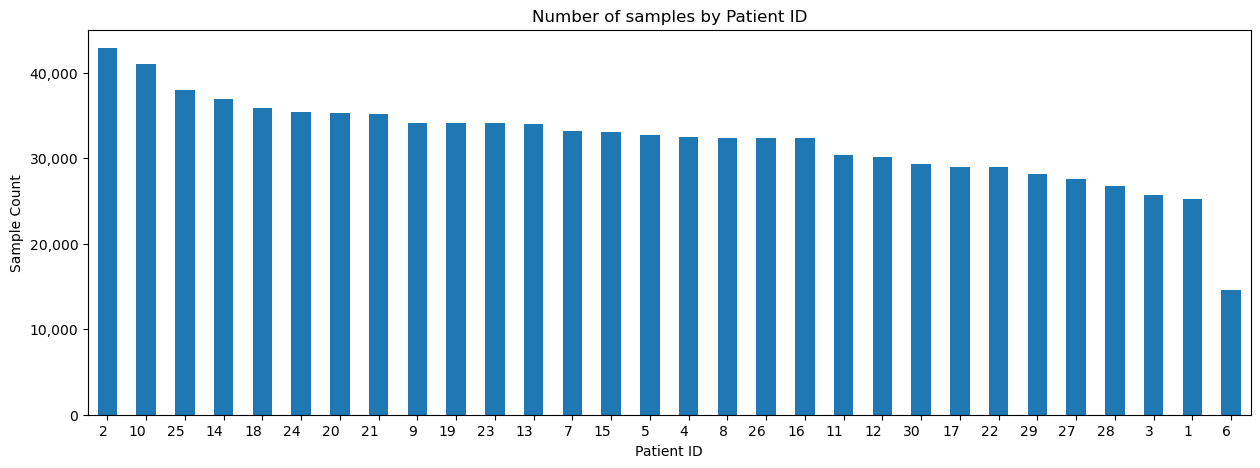

In [8]:
### Visualize dataste lenght for each patient
fig1 = plt.figure(figsize = (15, 5))
df.patient.value_counts().plot(kind='bar', logy= False)

plt.xlabel('Patient ID')
plt.xticks(rotation=0, ha="right")
plt.ylabel('Sample Count')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(k) for k in current_values])
plt.title('Number of samples by Patient ID')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

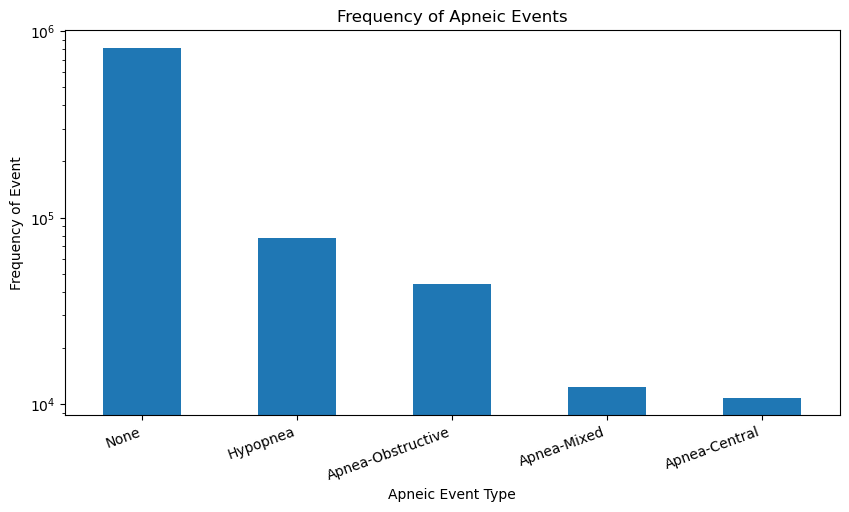

In [9]:
### Visualize frequency of each apneic event type
fig2 = plt.figure(figsize = (10, 5))
df.event.value_counts().plot(kind='bar', logy= True)

plt.xlabel('Apneic Event Type')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['None', 'Hypopnea', 'Apnea-Obstructive', 'Apnea-Mixed', 'Apnea-Central'])

plt.xticks(rotation=20, ha="right")
plt.ylabel('Frequency of Event')
plt.title('Frequency of Apneic Events')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

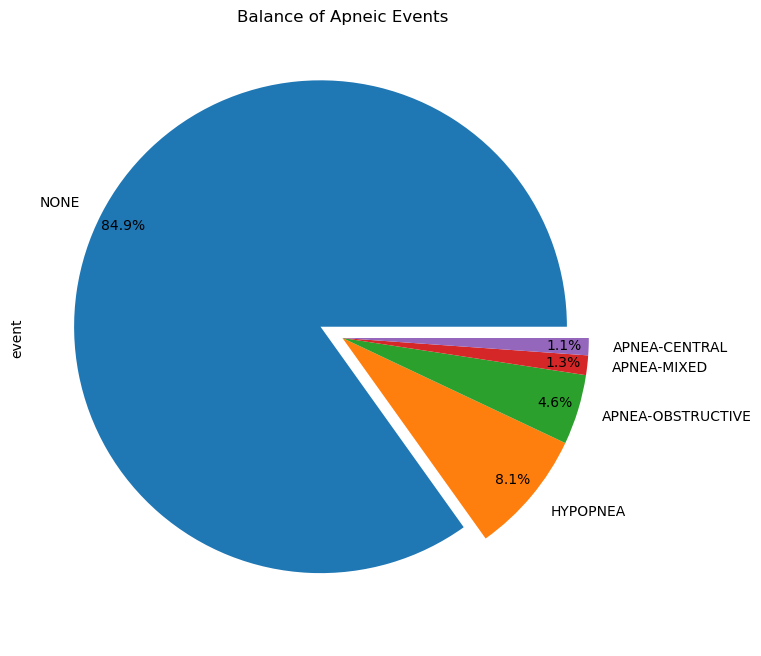

In [10]:
### Pie chart of apneic events
fig3 = plt.figure(figsize = (8, 8))
df.event.value_counts().plot.pie(y=False, title="Balance of Apneic Events", legend=False, autopct='%1.1f%%', pctdistance = 0.9, explode=(0.1, 0, 0, 0, 0), shadow=False, startangle=0)

plt.title('Balance of Apneic Events')
plt.show

In [11]:
### Ditribution of apneic evennts by patient
apnea=[]
pbar = tqdm(desc="Processed patients", total=len(df.patient.unique()))
for pat in np.unique(df.patient)[np.argsort(np.unique(df.patient).astype(np.int8))]:
    temp1 = df.loc[df.patient.eq(pat) & df.event.eq('NONE')]
    temp2 = df.loc[df.patient.eq(pat) & df.event.eq('HYPOPNEA')]
    temp3 = df.loc[df.patient.eq(pat) & df.event.eq('APNEA-OBSTRUCTIVE')]
    temp4 = df.loc[df.patient.eq(pat) & df.event.eq('APNEA-CENTRAL')]
    temp5 = df.loc[df.patient.eq(pat) & df.event.eq('APNEA-MIXED')]

    pandas_row = [pat, #patient ID
                  len(temp1), #NONE
                  len(temp2), #HYPOPNEA
                  len(temp3), #APNEA-OBSTRUCTIVE
                  len(temp4), #APNEA-CENTAL
                  len(temp5)  #APNEA-MIXED
                ]

    apnea.append(pandas_row)

    pbar.update(1)

apnea = pd.DataFrame(apnea, columns=['patient',
                                      'NONE',
                                      'HYPOPNEA',
                                      'APNEA-OBSTRUCTIVE',
                                      'APNEA-CENTRAL',
                                      'APNEA-MIXED'])

display(apnea)
                                              

Processed patients:   0%|          | 0/30 [00:00<?, ?it/s]

,patient,NONE,HYPOPNEA,APNEA-OBSTRUCTIVE,APNEA-CENTRAL,APNEA-MIXED
0,1,19308,3057,2548,102,163
1,2,40500,1866,449,23,39
2,3,15067,5237,4846,278,254
3,4,29348,1317,1776,36,0
4,5,25539,6515,529,158,0
5,6,10150,3076,1179,115,90
6,7,29053,3169,926,0,0
7,8,32191,146,60,0,0
8,9,32866,941,349,0,0
9,10,31387,4601,1785,1835,1450


Processed features:   0%|          | 0/5 [00:00<?, ?it/s]

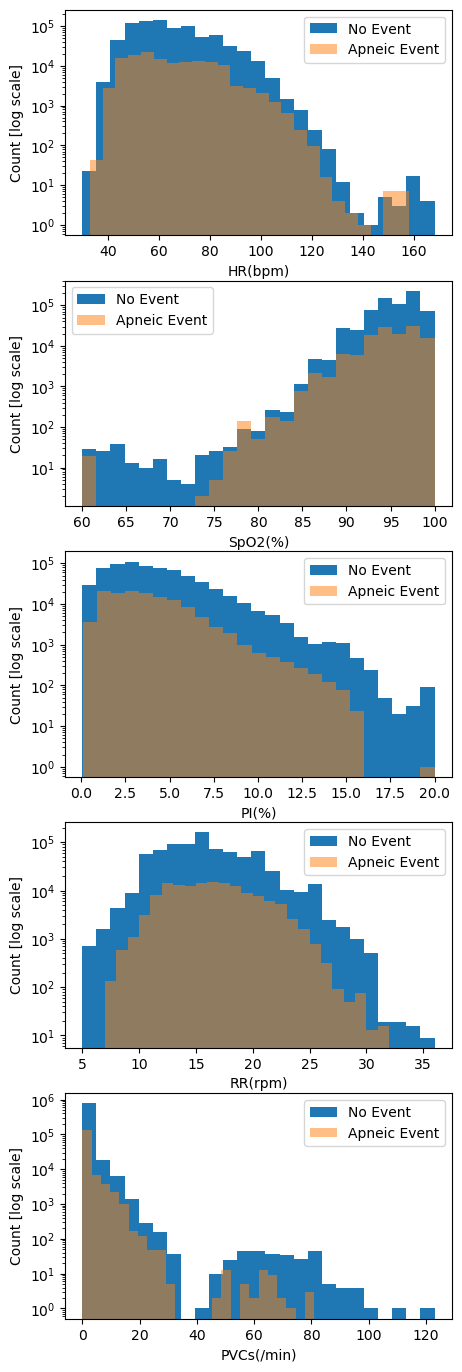

In [12]:
### Vizualizing the correlation between Cradiac Featurea and Presence of Apnea
fig = plt.figure(figsize=(5, 17))
plt.title('Histograms of Cardiac Metrics')
pbar = tqdm(desc="Processed features", total=5)
for i, column in enumerate(['HR(bpm)', 'SpO2(%)', 'PI(%)', 'RR(rpm)', 'PVCs(/min)']):
    ax1 = fig.add_subplot(1,2, 1)
    plt.subplot(5, 1, i+1)
    temp2 = df[column].loc[df.anomaly.eq(True)]
    temp1 = df[column].loc[df.anomaly.eq(False)]
    plt.hist(temp1, bins=25, alpha =1, label = 'No Event') 
    plt.hist(temp2, bins=25, alpha =0.5, label = 'Apneic Event')
    plt.yscale('log')
    plt.xlabel(column)
    plt.ylabel('Count [log scale]')
    if i == 1:
        plt.legend(loc='upper left')
    else:
        plt.legend(loc='upper right')
    pbar.update(1)
pbar.close()
plt.show()

In [4]:
### Function that outputs the "begin_index" and "end_index" of each contiguous block of TRUEs
def one_runs(a):
    iszero = np.concatenate(([0], np.equal(a, 1).astype(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [5]:
### Calculate validation data for each patient
validation_pandas = []
pbar = tqdm(desc="Processed patients", total=len(df.patient.unique()))
for pat in np.unique(df.patient)[np.argsort(np.unique(df.patient).astype(np.int8))]:
    temp = df[df.patient == pat]

    tmp_null_pleth = np.asarray([np.isnan(x) for x in temp['signal_pleth']]).flatten()
    tmp_null_ecg_i = np.asarray([np.isnan(x) for x in temp['signal_ecg_i']]).flatten()
    tmp_null_ecg_ii = np.asarray([np.isnan(x) for x in temp['signal_ecg_ii']]).flatten()
    tmp_null_ecg_iii = np.asarray([np.isnan(x) for x in temp['signal_ecg_iii']]).flatten()
    
    pandas_row = [pat, # patient ID
                  round(len(temp) / 3600, 1), # recording duration (hours)
                  round(len(one_runs(temp['anomaly'].values)) / (len(temp) / 3600), 1), # AHI 
                  len(one_runs(temp[temp['event'] != 'HYPOPNEA']['anomaly'])), # number of apnea events
                  len(one_runs(temp[(temp['event'] != 'APNEA-CENTRAL') & (temp['event'] != 'APNEA-MIXED') & (temp['event'] != 'APNEA-OBSTRUCTIVE')]['anomaly'])), # number of hypopnea events
                  round(np.mean([x[1] - x[0] + 1 for x in one_runs(temp['anomaly'].values)])), # average duration of (hypo)apnea events (seconds)
                  round(np.std([x[1] - x[0] + 1 for x in one_runs(temp['anomaly'].values)])), # standard deviation of the duration of (hypo)apnea events (seconds)
                  round(100 * np.sum(np.isnan(temp['HR(bpm)'])) / len(temp), 1), # percentage of null HR values
                  round(100 * np.sum(np.isnan(temp['SpO2(%)'])) / len(temp), 1), # percentage of null SpO2 values
                  round(100 * np.sum(np.isnan(temp['PI(%)'])) / len(temp), 1), # percentage of null PI values
                  round(100 * np.sum(np.isnan(temp['RR(rpm)'])) / len(temp), 1), # percentage of null RR values
                  round(100 * np.sum(np.isnan(temp['PVCs(/min)'])) / len(temp), 1), # percentage of null PVC values
                  round(100 * np.sum(tmp_null_pleth) / len(tmp_null_pleth), 1), # percentage of null pleth values,
                  round(100 * np.sum(tmp_null_ecg_i) / len(tmp_null_ecg_i), 1), # percentage of null ecg i values,
                  round(100 * np.sum(tmp_null_ecg_ii) / len(tmp_null_ecg_ii), 1), # percentage of null ecg ii values,
                  round(100 * np.sum(tmp_null_ecg_iii) / len(tmp_null_ecg_iii), 1), # percentage of null ecg iii values
                 ]
    
    validation_pandas.append(pandas_row)
    
    pbar.update(1)
    
        
validation_pandas = pd.DataFrame(validation_pandas, columns=['patient', 
                                                             'recording duration (hrs)', 
                                                             'AHI', 
                                                             '# apnea events', 
                                                             '# hypopnea events', 
                                                             'avg duration (hypo)apnea events',
                                                             'stddev duration (hypo)apnea events',
                                                             '% null HR',
                                                             '% null SpO2',
                                                             '% null PI', 
                                                             '% null RR', 
                                                             '% null PVC',
                                                             '% null pleth',
                                                             '% null ecg i',
                                                             '% null ecg ii',
                                                             '% null ecg iii'
                                                            ])

display(validation_pandas)

Processed patients:   0%|          | 0/30 [00:00<?, ?it/s]

,patient,recording duration (hrs),AHI,# apnea events,# hypopnea events,avg duration (hypo)apnea events,stddev duration (hypo)apnea events,% null HR,% null SpO2,% null PI,% null RR,% null PVC,% null pleth,% null ecg i,% null ecg ii,% null ecg iii
0,1,7.0,39.7,142,136,22,8,0.0,8.3,8.5,0.0,0.0,8.2,0.0,0.0,0.0
1,2,11.9,10.2,29,93,20,8,0.0,6.1,6.1,0.0,0.0,6.1,0.3,0.0,53.8
2,3,7.1,63.1,242,208,25,10,0.0,0.2,0.4,2.7,0.0,0.0,0.0,0.0,0.0
3,4,9.0,10.4,52,42,34,15,0.3,0.2,0.3,0.7,0.3,0.2,1.4,0.2,1.4
4,5,9.1,35.4,42,280,23,12,1.9,3.6,3.6,1.6,1.9,3.4,1.5,1.4,1.5
5,6,4.1,58.4,87,150,20,4,0.9,1.6,1.9,0.1,0.9,0.0,0.0,0.0,0.0
6,7,9.2,29.9,72,203,16,3,0.0,11.1,11.2,1.2,0.0,10.9,0.0,0.0,0.0
7,8,9.0,1.4,3,10,17,3,0.0,12.1,12.1,0.0,0.0,11.8,0.0,0.0,0.0
8,9,9.5,8.1,24,53,18,5,0.3,13.4,13.5,0.4,0.3,13.3,0.3,0.3,0.3
9,10,11.4,41.4,265,207,21,6,5.8,17.8,17.9,5.9,5.8,17.5,5.8,5.8,5.8


Processed features:   0%|          | 0/5 [00:00<?, ?it/s]

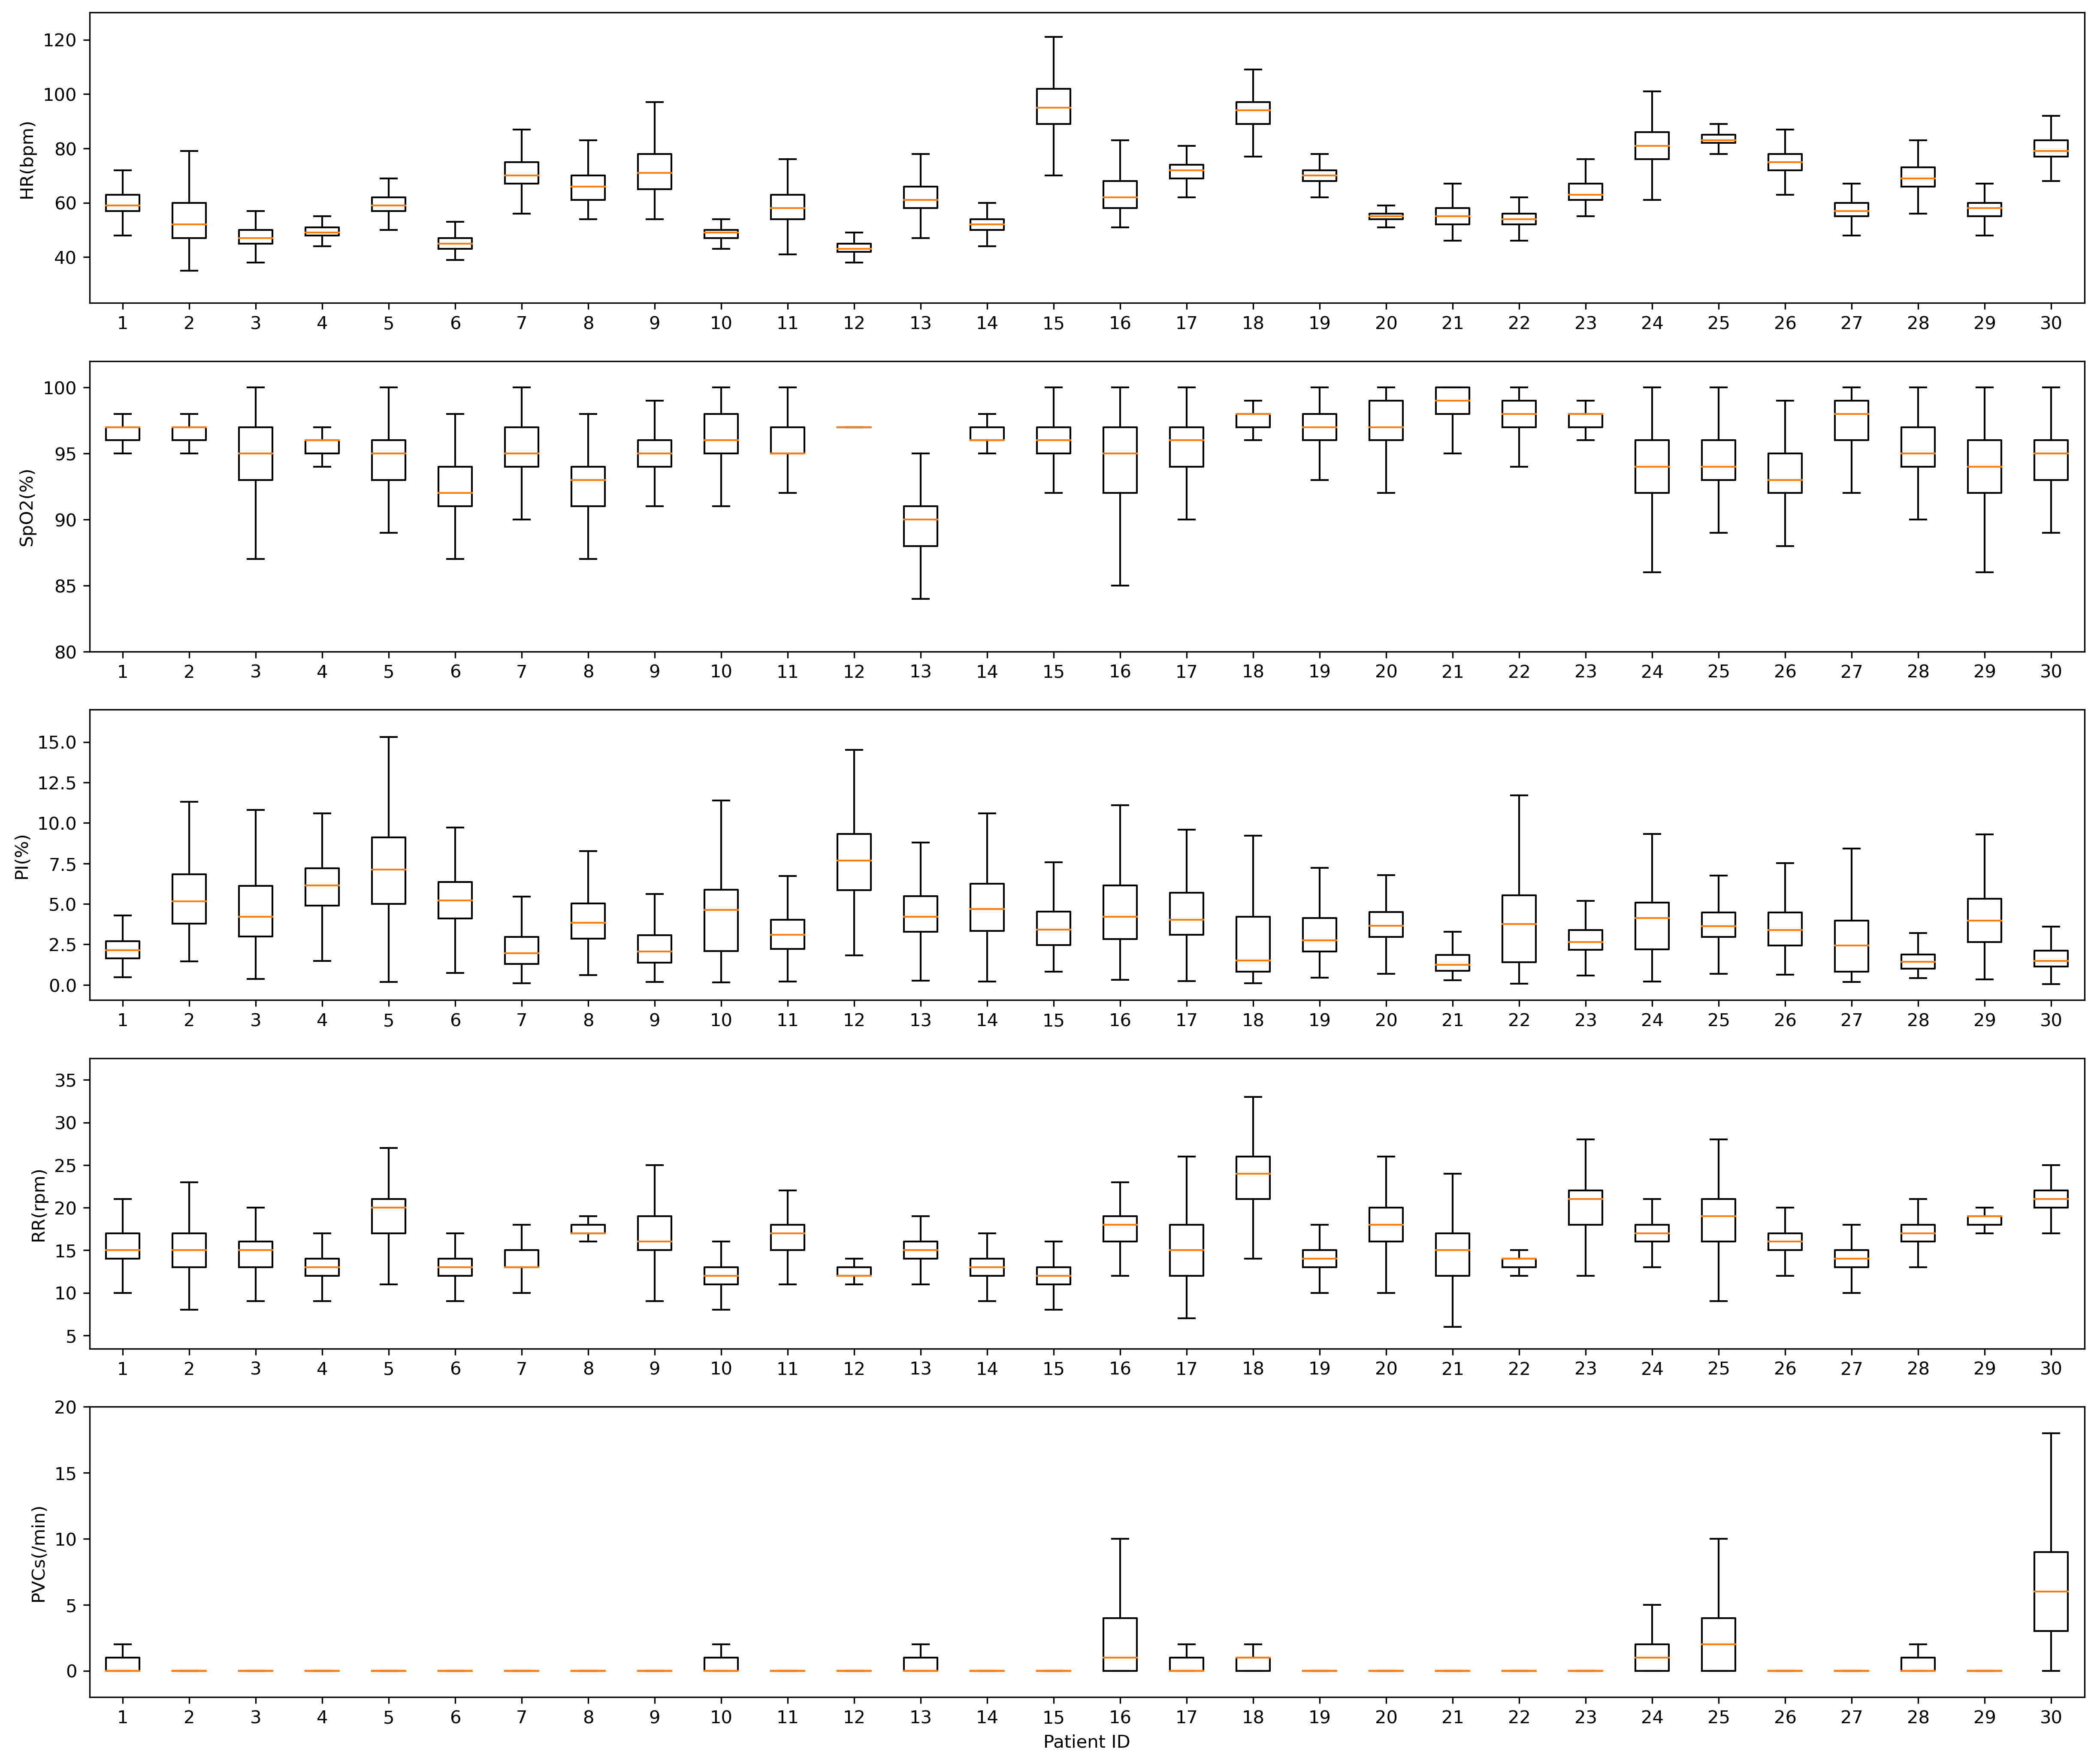

In [63]:
### Boxplots of Cardiac Features over Patients
plt.figure(figsize=(20, 17), dpi=300)
plt.title('Boxplots of Cardiac Features over Patients')
pbar = tqdm(desc="Processed features", total=5)
for i, column in enumerate(['HR(bpm)', 'SpO2(%)', 'PI(%)', 'RR(rpm)', 'PVCs(/min)']):
    plt.subplot(5, 1, i+1)
    plot_data = []
    for pat in np.unique(df.patient)[np.argsort(np.unique(df.patient).astype(np.int8))]:
        temp = df[df.patient == pat][column]
        plot_data.append([x for x in list(temp.values) if not np.isnan(x)])
    plt.boxplot(plot_data, sym='-')
    if i == 0:
        plt.ylim(top=130)
    if i == 1:
        plt.ylim(bottom=80)
    if i == 2:
        plt.ylim(top=17)
    if i == 4:
        plt.ylim(top=20)
        plt.ylim(bottom=-2)
        plt.xlabel("Patient ID")
    plt.ylabel(column)
    pbar.update(1)
pbar.close()
plt.show()

Processed features:   0%|          | 0/5 [00:00<?, ?it/s]

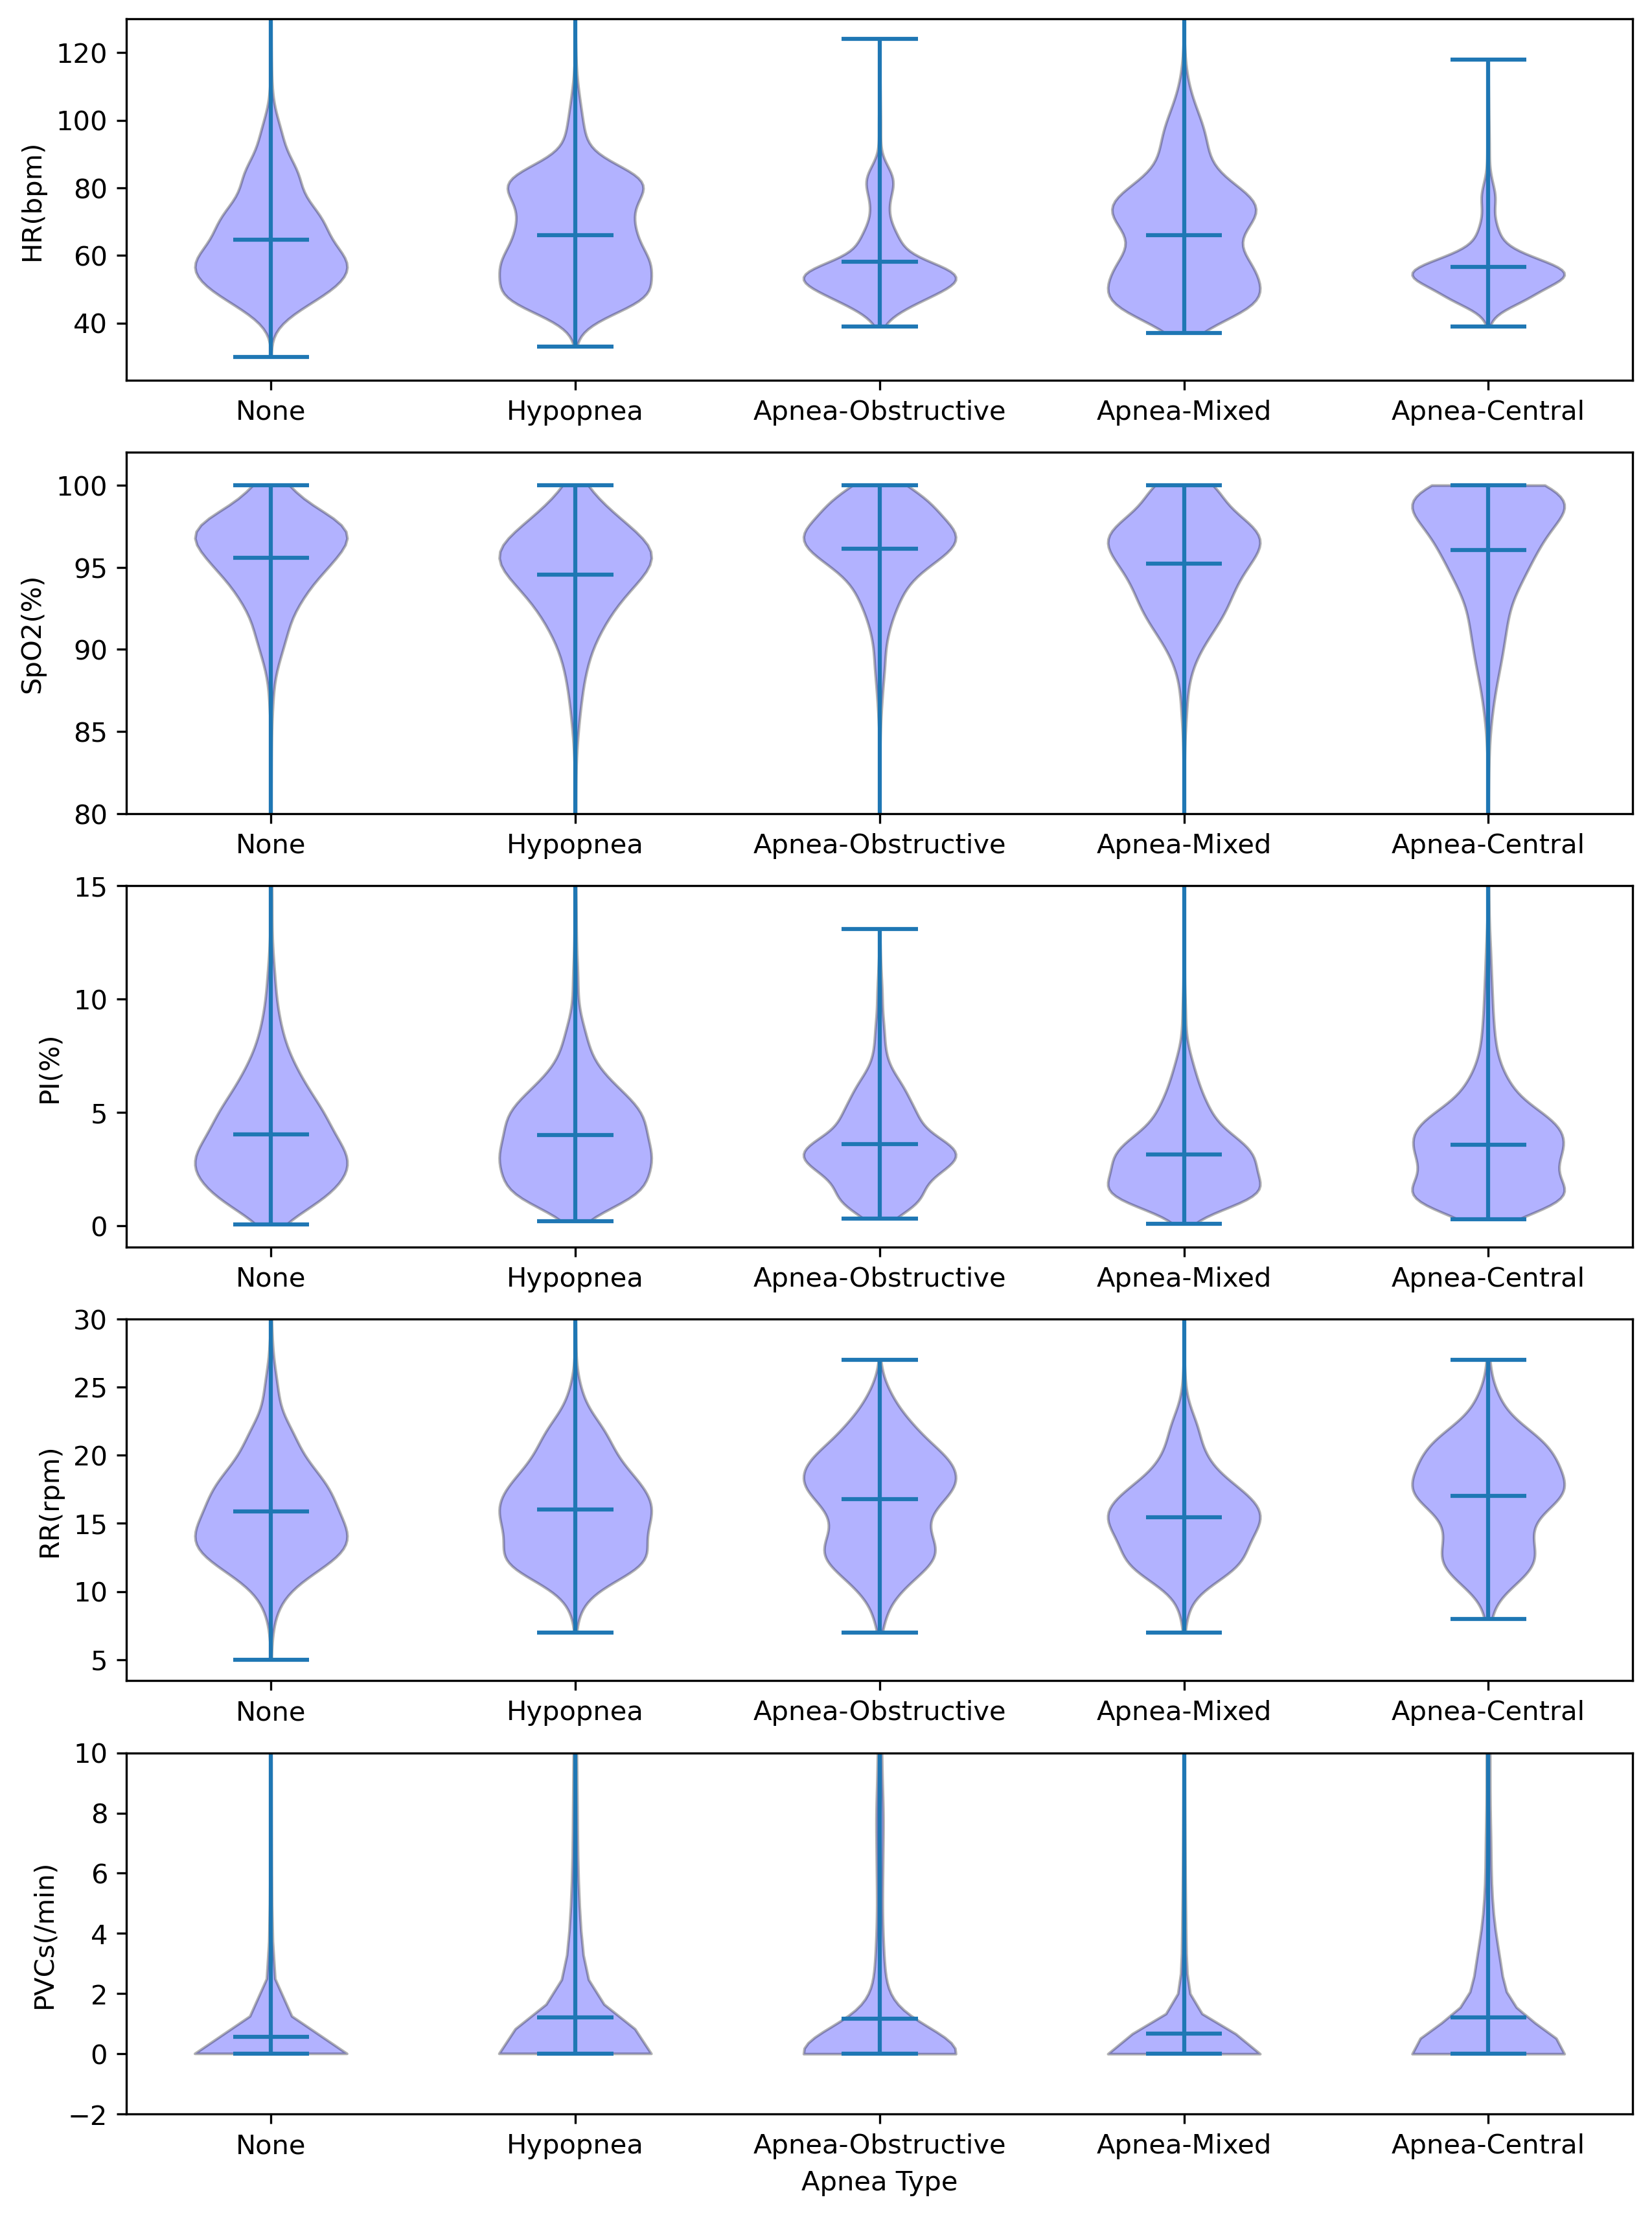

In [84]:
### Violin Plots of Cardiac Features over Apnea Types
plt.figure(figsize=(10, 14),dpi=300)
plt.title('Violin Plots of Cardiac Features over Apnea Types')
pbar = tqdm(desc="Processed features", total=5)
for i, column in enumerate(['HR(bpm)', 'SpO2(%)', 'PI(%)', 'RR(rpm)', 'PVCs(/min)']):
    plt.subplot(5, 1, i+1)
    plot_data = []
    for apn in np.unique(df.event):
        temp = df[df.event == apn][column]
        plot_data.append([x for x in list(temp.values) if not np.isnan(x)])
    
    violin_parts = plt.violinplot(plot_data, showextrema = True, showmeans=True, bw_method=0.3)

    for pc in violin_parts['bodies']:
        pc.set_facecolor('blue')
        pc.set_edgecolor('black')   

    if i == 0:
        plt.ylim(top=130)
    if i == 1:
        plt.ylim(bottom=80)
    if i == 2:
        plt.ylim(top=15)
    if i == 3:
        plt.ylim(top=30)
    if i == 4:
        plt.ylim(top=10)
        plt.ylim(bottom=-2)       
        plt.xlabel("Apnea Type")
    plt.ylabel(column)
    plt.xticks([1,2,3,4,5], ['None', 'Hypopnea', 'Apnea-Obstructive', 'Apnea-Mixed', 'Apnea-Central'])
    pbar.update(1)
pbar.close()
plt.show() 

In [17]:
### Calculate average metrics for each patient
average_metrics = []
pbar = tqdm(desc="Processed patients", total=len(df.patient.unique()))
for pat in np.unique(df.patient)[np.argsort(np.unique(df.patient).astype(np.int8))]:
    temp = df[df.patient == pat]
    
    pandas_row = [pat, # patient ID
                  round(len(one_runs(temp['anomaly'].values)) / (len(temp) / 3600), 1), # AHI 
                  temp['HR(bpm)'].mean(), # average HR 
                  temp['SpO2(%)'].mean(), # average SpO2
                  temp['PI(%)'].mean(), # average PI 
                  temp['RR(rpm)'].mean(), # average RR
                  temp['PVCs(/min)'].mean() # average PVC
                 ]
    
    average_metrics.append(pandas_row)
    
    pbar.update(1)  

average_metrics = pd.DataFrame(average_metrics, columns=['patient',
                                                         'AHI',
                                                         'avg HR(bpm)',
                                                         'avg SpO2(%)',
                                                         'avg PI(%)',
                                                         'avg RR(rpm)',
                                                         'avg PVCs(/min)'
                                                        ])

display(average_metrics)

Processed patients:   0%|          | 0/30 [00:00<?, ?it/s]

,patient,AHI,avg HR(bpm),avg SpO2(%),avg PI(%),avg RR(rpm),avg PVCs(/min)
0,1,39.7,61.642729,96.382436,2.256236,15.545657,0.838940
1,2,10.2,53.755704,96.574135,5.428906,15.075872,0.157412
2,3,63.1,47.493264,94.885009,4.693121,14.300268,0.042053
3,4,10.4,50.301746,95.633345,6.148950,13.244063,0.063927
4,5,35.4,60.254836,94.534630,7.225170,18.942276,0.424820
5,6,58.4,45.579082,92.436113,5.178429,13.319263,0.000000
6,7,29.9,70.923641,95.541603,2.359996,13.793061,0.005431
7,8,1.4,65.793215,92.479069,4.016711,17.527040,0.016669
8,9,8.1,72.187764,94.630238,2.302199,16.698125,0.046728
9,10,41.4,49.850251,96.559443,4.208868,12.335438,0.512417


Processed features:   0%|          | 0/5 [00:00<?, ?it/s]

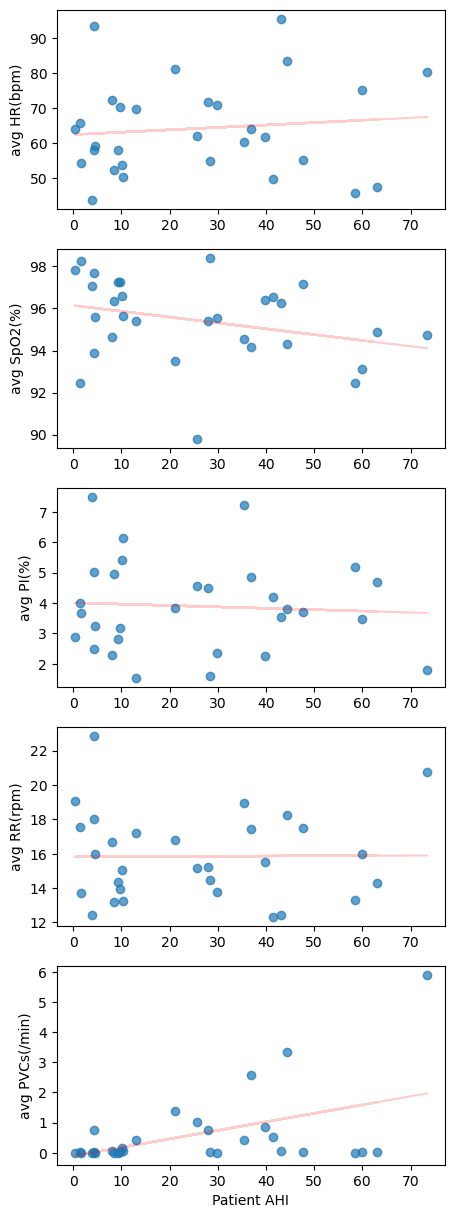

In [18]:
### Vizualizing the correlation between Cradiac Feature Average/Patient and Patient AHI
plt.figure(figsize=(5, 15))
plt.title('Histograms of Average Cardiac Metrics vs Patient AHI')
pbar = tqdm(desc="Processed features", total=5)
for i, column in enumerate(['avg HR(bpm)', 'avg SpO2(%)', 'avg PI(%)', 'avg RR(rpm)', 'avg PVCs(/min)']):
    plt.subplot(5, 1, i+1)
    temp = average_metrics[column]
    plt.scatter(average_metrics['AHI'], temp, alpha =0.7)
    x = average_metrics['AHI'].values
    y = temp.values
    z = np.polyfit(x,y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x), 'r-', alpha =0.2)   
    if i == 4:      
        plt.xlabel("Patient AHI")
    plt.ylabel(column)
    pbar.update(1)
pbar.close()
plt.show()

In [19]:
### Isloate Target variables and creating a separate dataset with objects
y = df[['event']]
yy = df[['anomaly']]

groups = df[['patient']]

X = df.drop(['event', 'anomaly'], axis=1)
X_obj = X[['patient', 'timestamp_datetime', 'signal_pleth', 'signal_ecg_i', 'signal_ecg_ii', 'signal_ecg_iii', 'PSG_Abdomen', 'PSG_Flow', 'PSG_Position', 'PSG_Snore', 'PSG_Thorax']]
X = X.drop(['timestamp_datetime', 'signal_pleth', 'signal_ecg_i', 'signal_ecg_ii', 'signal_ecg_iii', 'PSG_Abdomen', 'PSG_Flow', 'PSG_Position', 'PSG_Snore', 'PSG_Thorax'], axis=1)

#display(X_obj.head())

In [20]:
### Splitting Non-object Dataset with 5 labels
n_splits = 5
random_state = 42

def pd_unique_counter(x):
    nested_lst = x.values.tolist()
    flat_lst = list(np.concatenate(nested_lst))
    unique = set(flat_lst)
    return len(unique)

### Convert y to label indices rather than label names
y.replace(['NONE', 'HYPOPNEA', 'APNEA-CENTRAL', 'APNEA-OBSTRUCTIVE', 'APNEA-MIXED'], [0, 1, 2, 3 ,4], inplace =True)

### Group Shuffle Split to isolate Test Set
# create test set based on groups
gss = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=random_state)
for i_other,i_test in gss.split(X, y, groups):
    X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
    X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]

# Split train and val sets based on groups
gkf = GroupKFold(n_splits=n_splits)
for i_train,i_val in gkf.split(X_other, y_other, groups_other):
    X_train, y_train, groups_train = X_other.iloc[i_train], y_other.iloc[i_train], groups_other.iloc[i_train]
    X_val, y_val, groups_val = X_other.iloc[i_val], y_other.iloc[i_val], groups_other.iloc[i_val]

# check the split
print('Number of groups in Dataset:   ',pd_unique_counter(groups))
print('Number of groups in Train Set: ',pd_unique_counter(groups_train))
print('Number of groups in Val Set:   ',pd_unique_counter(groups_val))
print('Number of groups in Test Set:  ',pd_unique_counter(groups_test))
    

C:\Users\petru\AppData\Local\Temp\ipykernel_19696\3626368465.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.replace(['NONE', 'HYPOPNEA', 'APNEA-CENTRAL', 'APNEA-OBSTRUCTIVE', 'APNEA-MIXED'], [0, 1, 2, 3 ,4], inplace =True)


Number of groups in Dataset:    30
Number of groups in Train Set:  19
Number of groups in Val Set:    5
Number of groups in Test Set:   6


<AxesSubplot:title={'center':'GroupKFold'}, xlabel='Sample index', ylabel='CV iteration'>

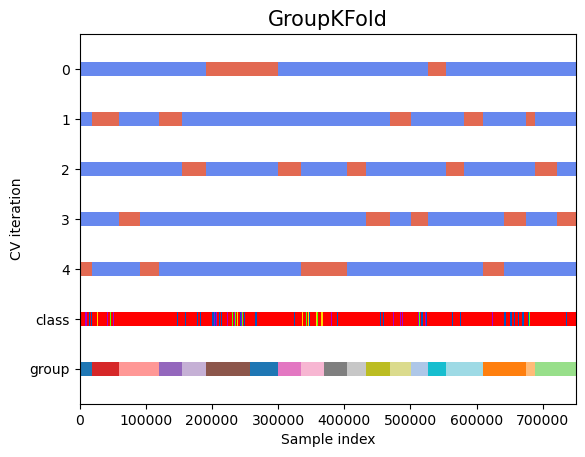

In [21]:
### Visualize Splits
# combine and sort based on group and label
def plot_cv_indices_group(cv, X, y, group, ax, n_splits, lw=10):
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data1
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data2
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 750000],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

# adjust colormap
cmap_data1 = plt.cm.prism
cmap_data2 = plt.cm.tab20
cmap_cv = plt.cm.coolwarm

# return plot
fig, ax = plt.subplots()
cv = gkf
plot_cv_indices_group(cv, X_other.values.tolist(), y_other.values.tolist(), groups_other.values.tolist(), ax, n_splits)

In [22]:
### Splitting Non-object Dataset with 2 labels
n_splits = 5
random_state = 42

def pd_unique_counter(x):
    nested_lst = x.values.tolist()
    flat_lst = list(np.concatenate(nested_lst))
    unique = set(flat_lst)
    return len(unique)

### Convert y to label indices rather than label names
yy.replace([False, True], [0, 1], inplace =True)

### Group Shuffle Split to isolate Test Set
# create test set based on groups
gss = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=random_state)
for i_other,i_test in gss.split(X, yy, groups):
    X_other, yy_other, groups_other = X.iloc[i_other], yy.iloc[i_other], groups.iloc[i_other]
    X_test, yy_test, groups_test = X.iloc[i_test], yy.iloc[i_test], groups.iloc[i_test]

# Split train and val sets based on groups
gkf = GroupKFold(n_splits=n_splits)
for i_train,i_val in gkf.split(X_other, yy_other, groups_other):
    X_train, yy_train, groups_train = X_other.iloc[i_train], yy_other.iloc[i_train], groups_other.iloc[i_train]
    X_val, yy_val, groups_val = X_other.iloc[i_val], yy_other.iloc[i_val], groups_other.iloc[i_val]

# check the split
print('Number of groups in Dataset:   ',pd_unique_counter(groups))
print('Number of groups in Train Set: ',pd_unique_counter(groups_train))
print('Number of groups in Val Set:   ',pd_unique_counter(groups_val))
print('Number of groups in Test Set:  ',pd_unique_counter(groups_test))

C:\Users\petru\AppData\Local\Temp\ipykernel_19696\4062393494.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yy.replace([False, True], [0, 1], inplace =True)


Number of groups in Dataset:    30
Number of groups in Train Set:  19
Number of groups in Val Set:    5
Number of groups in Test Set:   6


<AxesSubplot:title={'center':'GroupKFold'}, xlabel='Sample index', ylabel='CV iteration'>

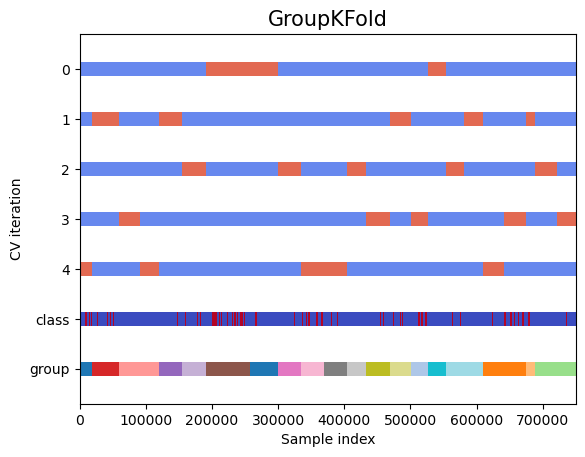

In [24]:
### Visualize Splits
# combine and sort based on group and label
def plot_cv_indices_group(cv, X, y, group, ax, n_splits, lw=10):
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data1
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data2
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 750000],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

# adjust colormap
cmap_data1 = plt.cm.coolwarm
cmap_data2 = plt.cm.tab20
cmap_cv = plt.cm.coolwarm

# return plot
fig, ax = plt.subplots()
cv = gkf
plot_cv_indices_group(cv, X_other.values.tolist(), yy_other.values.tolist(), groups_other.values.tolist(), ax, n_splits)

In [ ]:
#############################TODO####################################################
### Preprocess Non-object Dataset
# Preprocess X
minmax_ftrs = ['HR(bpm)', 'SpO2(%)', 'PI(%)', 'RR(rpm)']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])



Text(0, 0.5, 'Amplitude (mV)')

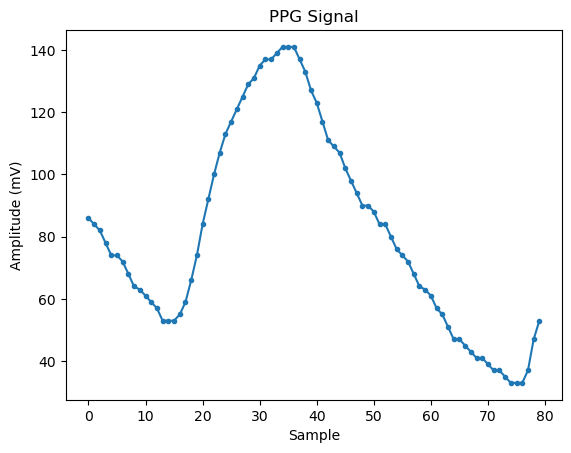

In [25]:
### Plot one object sample from each columns
temp = X_obj['signal_pleth'][961356]
x = np.arange(len(temp))
plt.plot(x, temp, marker='o', markersize=3)
plt.title('PPG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')

Text(0, 0.5, 'Amplitude (mV)')

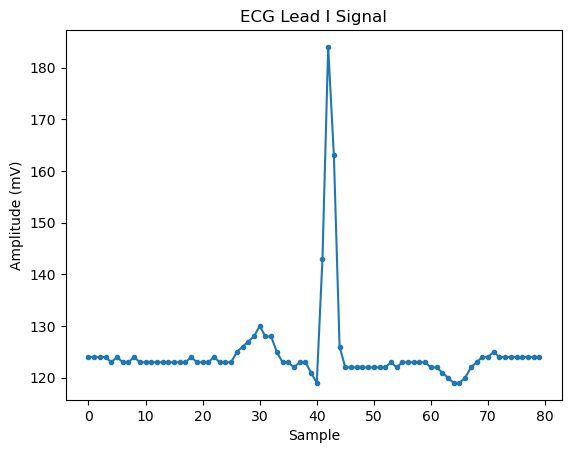

In [26]:
temp = X_obj['signal_ecg_i'][3]
x = np.arange(len(temp))
plt.plot(x, temp, marker='o', markersize=3)
plt.title('ECG Lead I Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')

Text(0, 0.5, 'Amplitude (mV)')

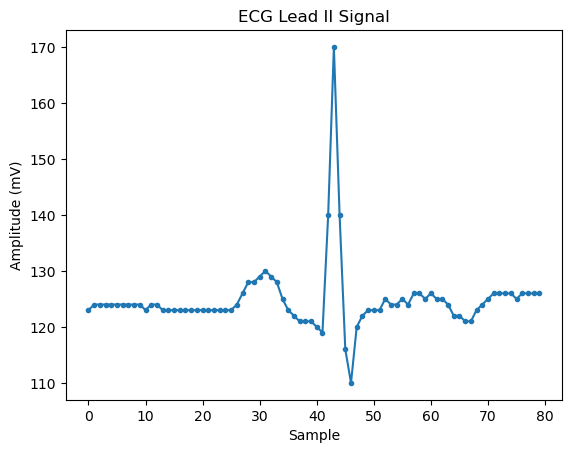

In [27]:
temp = X_obj['signal_ecg_ii'][2]
x = np.arange(len(temp))
plt.plot(x, temp, marker='o', markersize=3)
plt.title('ECG Lead II Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')

Text(0, 0.5, 'Amplitude (mV)')

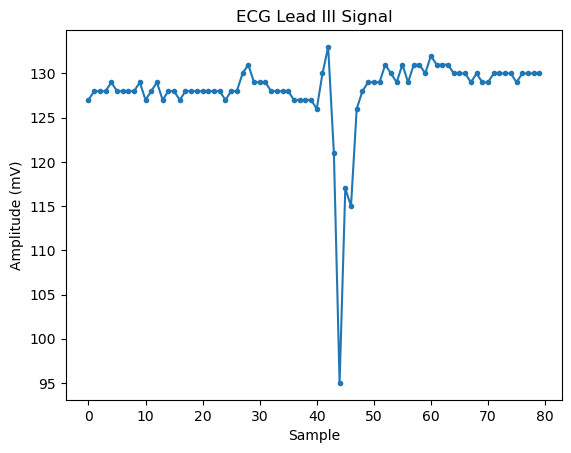

In [28]:
temp = X_obj['signal_ecg_iii'][2]
x = np.arange(len(temp))
plt.plot(x, temp, marker='o', markersize=3)
plt.title('ECG Lead III Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')

Text(0, 0.5, 'Amplitude (mV)')

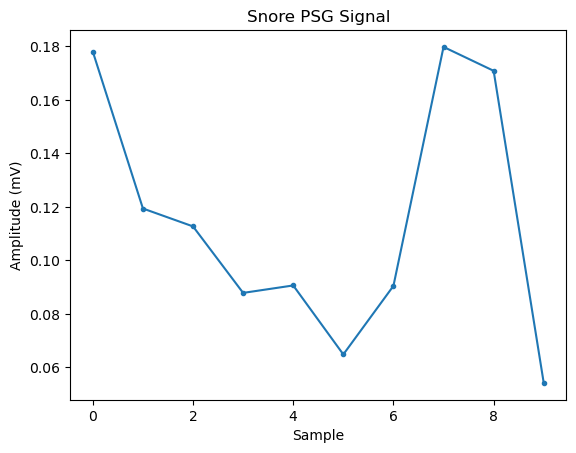

In [29]:
temp = X_obj['PSG_Snore'][2]
x = np.arange(len(temp))
plt.plot(x, temp, marker='o', markersize=3)
plt.title('Snore PSG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')

Text(0, 0.5, 'Amplitude (mV)')

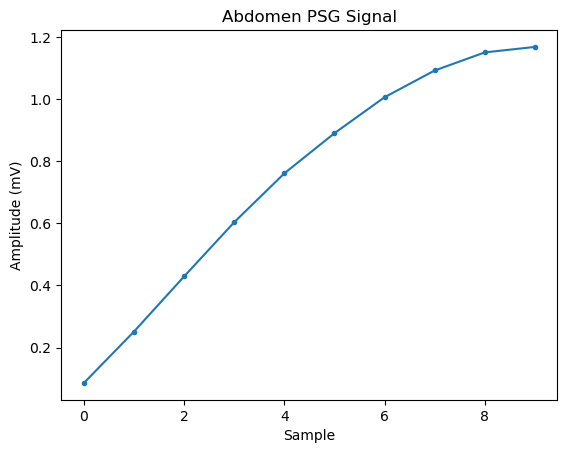

In [30]:
temp = X_obj['PSG_Abdomen'][2]
x = np.arange(len(temp))
plt.plot(x, temp, marker='o', markersize=3)
plt.title('Abdomen PSG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')

In [6]:
### Re-assemble time-series for each patient to create a continuous signal from objects
df['event'].replace(['NONE', 'HYPOPNEA', 'APNEA-CENTRAL', 'APNEA-OBSTRUCTIVE', 'APNEA-MIXED'], [0, 1, 2, 3 ,4], inplace =True)
df['anomaly'].replace([False, True], [0, 1], inplace =True)
df = df.drop(['anomaly'], axis=1)
df = df.drop(['signal_pleth'], axis=1)

patient_map_features = {} # given a patient, the map returns a map that, given feature, returns its whole time series
pbar = tqdm(desc="Processed patients", total=len(df['patient'].unique()))
for pat in df['patient'].unique():
    temp = df[df['patient'] == pat]
    feature_map_ts = {}
    for col in df.columns[1:]:
        if 'signal' not in col and 'PSG_' not in col:
            feature_map_ts[col] = temp[col].values
        else:
            feature_map_ts[col] = np.concatenate(temp[col].values)
    patient_map_features[pat] = feature_map_ts
    pbar.update(1)
pbar.close()

Processed patients:   0%|          | 0/30 [00:00<?, ?it/s]

In [71]:
### Restructure data on numpy array of 16008 windows, of 60 seconds each, for each feature and target
window_seconds = 60 # length, in seconds, of each data window

derived_data = [] # will be a numpy array containing ECG and PPG derived data
waveform_data = [] # will be a numpy array containing ECG and PPG waveform data
label_data = [] # will be a numpy array containing the "event" and anomaly" data labels

list_patients = [] # list that keeps track of the patient ID for each row in the arrays
list_derived_columns = [] # list that keeps track of the column names in the derived_data numpy array (last dimension)
list_waveform_columns = [] # list that keeps track of the column names in the waveform_data numpy array (last dimension)
list_label_columns = [] # list that keeps track of the column names in the label_data numpy array (last dimension)


pbar = tqdm(desc="Processed patients", total=len(df['patient'].unique()))
for pat in patient_map_features.keys():
    num_values = len(patient_map_features[pat]['HR(bpm)'])
    max_values = (num_values // window_seconds) * window_seconds
    
    # Non-Object data
    temp_list_derived = []
    derived_colnames = []
    for col in patient_map_features[pat]:
        if np.any([x == col for x in ['HR(bpm)', 'SpO2(%)', 'PI(%)', 'RR(rpm)', 'PVCs(/min)']]):
            temp_list_derived.append(np.asarray(patient_map_features[pat][col][:max_values]).reshape(-1, window_seconds))
            derived_colnames.append(col)
    temp_list_derived = np.moveaxis(np.asarray(temp_list_derived), [0, 1, 2], [2, 0, 1])
    derived_data.append(temp_list_derived)
    if len(list_derived_columns) == 0:
        list_derived_columns = derived_colnames
    
    # Object data
    temp_list_waveform = []
    waveform_colnames = []
    for col in patient_map_features[pat]:
        if 'signal' in col:
            temp_list_waveform.append(np.asarray(patient_map_features[pat][col][:max_values*80]).reshape(-1, window_seconds, 80))
            waveform_colnames.append(col)
    temp_list_waveform = np.moveaxis(np.asarray(temp_list_waveform), [0, 1, 2, 3], [3, 0, 1, 2])
    waveform_data.append(temp_list_waveform)    
    if len(list_waveform_columns) == 0:
        list_waveform_columns = waveform_colnames
    
    # Label data
    temp_list_label = []
    label_colnames = []
    for col in patient_map_features[pat]:
        if col == 'event': #or col == 'anomaly':
            temp_list_label.append(np.asarray(patient_map_features[pat][col][:max_values]).reshape(-1, window_seconds))
            label_colnames.append(col)
    temp_list_label = np.moveaxis(np.asarray(temp_list_label), [0, 1, 2], [2, 0, 1])
    label_data.append(temp_list_label)
    if len(list_label_columns) == 0:
        list_label_columns = label_colnames
    
    # Auxiliary data that keeps track of the patient related to each row
    list_patients.extend([pat] * temp_list_derived.shape[0])
    
    pbar.update(1)
pbar.close()

derived_data = np.vstack(derived_data) # 16008 windows, of 60 seconds each, for 5 attributes
waveform_data = np.vstack(waveform_data) # 16008 windows, of 60 seconds each, 80 values per second
label_data = np.vstack(label_data) # 16008 windows, of 60 seconds each, for event labels

Processed patients:   0%|          | 0/30 [00:00<?, ?it/s]

In [118]:
print(patient_map_features['1']['signal_ecg_i'].shape)
print(patient_map_features['1']['HR(bpm)'].shape)
num_values = len(patient_map_features['1']['HR(bpm)'])
max_values = (num_values // window_seconds) * window_seconds
print(num_values)
print(max_values)

waveform_data = []
derived_data = []
hrv_data = []
hrv_columns = []

label_data =[]
list_patients = []

window_seconds = 61
sampling_rate= 80

for i in range(30,33):#(window_seconds//2, num_values-1-window_seconds//2):
    print(i)
    mid_index = sampling_rate*(i+1/2)
    start_index = int(mid_index - window_seconds*sampling_rate/2)
    end_index = int(mid_index + window_seconds*sampling_rate/2)
    #print(start_index)
    #print(end_index)

    temp_w = patient_map_features['1']['signal_ecg_i'][start_index : end_index]
    temp_d =[]

    ecg_cleaned = nk.ecg_clean(temp_w, sampling_rate=sampling_rate)

    if np.sum(~np.isnan(ecg_cleaned)) < 800:
        print(np.sum(~np.isnan(ecg_cleaned)))
        continue

    for col in ['HR(bpm)', 'SpO2(%)', 'PI(%)', 'RR(rpm)', 'PVCs(/min)']:
        temp=patient_map_features['1'][col][i]
        temp_d.append(temp)
        #print(temp_d)

    peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate, correct_artifacts=True)
    hrv_ind = nk.hrv(peaks, sampling_rate=sampling_rate, show=False)
    #print(hrv_ind.columns.values.tolist())

    #temp_d = patient_map_features['1']['HR(bpm)'][i]
    #print(temp_d)
    derived_data.append(np.asarray(temp_d))
    waveform_data.append(np.asarray(temp_w))
    hrv_data.append(np.asarray(hrv_ind.values.tolist()))

    temp_l = patient_map_features['1']['event'][i]
    label_data.append(np.asarray(temp_l))

    list_patients.append(np.asarray('1'))

    if len(hrv_columns) == 0:
        hrv_columns = hrv_ind.columns.values.tolist()




derived_data = np.vstack(derived_data)
waveform_data = np.vstack(waveform_data)
hrv_data = np.vstack(hrv_data)
label_data = np.vstack(label_data)
list_patients = np.vstack(list_patients)

testdf=pd.DataFrame(hrv_data)
display(testdf)
print(derived_data)
print(list_patients)
print(label_data)
print(hrv_columns)
print(len(hrv_columns))

(2014240,)
(25178,)
25178
25132
30
31
32


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,892.910448,59.758981,NaN,NaN,NaN,NaN,NaN,NaN,50.658542,51.023899,...,2.484907,3.915211,1.297401,0.000000,0.0,0.0,1.744132,1.847626,3.088710,0.905386
1,891.791045,59.613347,NaN,NaN,NaN,NaN,NaN,NaN,50.751922,51.128010,...,2.639057,3.909770,1.285376,1.107704,0.0,0.0,1.751116,1.861353,3.111087,0.905386
2,890.671642,59.445962,NaN,NaN,NaN,NaN,NaN,NaN,50.377364,50.727516,...,2.639057,3.892677,1.261399,0.000000,0.0,0.0,1.766357,1.863320,2.533081,0.905386


[[68. nan nan 14.  0.]
 [67. nan nan 14.  0.]
 [66. nan nan 15.  0.]]
[['1']
 ['1']
 ['1']]
[[0]
 [0]
 [0]]
['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S', 'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS', 'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d', 'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa', 'HRV_DFA_alpha1', 'HRV_MFDFA_alpha1_Width', 'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha1_Mean', 'HRV_MFDFA_alpha1_Max', 'HRV_MFDFA_alpha1_Delta', 'HRV_MFDFA_alpha1_A

In [119]:
waveform_data = []
derived_data = []
hrv_data = []
label_data =[]

list_patients = [] # list that keeps track of the patient ID for each row in the arrays
hrv_colums =[] #list that keeps track of the column names in the hrv_data

window_seconds = 61
sampling_rate= 80

pbar = tqdm(desc="Processed patients", total=len(df['patient'].unique()))
for pat in patient_map_features.keys():
    num_values = len(patient_map_features[pat]['HR(bpm)'])

    for i in range(window_seconds//2, num_values -1 - window_seconds//2):
        mid_index = sampling_rate*(i+1/2)
        start_index = int(mid_index - window_seconds*sampling_rate/2)
        end_index = int(mid_index + window_seconds*sampling_rate/2)

        temp_w = patient_map_features[pat]['signal_ecg_i'][start_index : end_index]
        temp_d = []

        ecg_cleaned = nk.ecg_clean(temp_w, sampling_rate=sampling_rate)
        
        #skip index if less than 10 contractions in the window
        if np.sum(~np.isnan(ecg_cleaned)) < sampling_rate*10:
            print('index ', i, ' skipped')
            continue

        peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate, correct_artifacts=True)
        hrv_ind = nk.hrv(peaks, sampling_rate=sampling_rate, show=False)
        
        for col in ['HR(bpm)', 'SpO2(%)', 'PI(%)', 'RR(rpm)', 'PVCs(/min)']:
            temp=patient_map_features[pat][col][i]
            temp_d.append(temp)

        temp_l = patient_map_features[pat]['event'][i]

        derived_data.append(np.asarray(temp_d))
        waveform_data.append(np.asarray(temp_w))
        hrv_data.append(np.asarray(hrv_ind.values.tolist()))
        label_data.append(np.asarray(temp_l))
        list_patients.append(np.asarray(pat))

        if len(hrv_colums) == 0:
            hrv_colums = hrv_ind.columns.values.tolist()

    pbar.update(1)
pbar.close()

derived_data = np.vstack(derived_data)
waveform_data = np.vstack(waveform_data)
hrv_data = np.vstack(hrv_data)
label_data = np.vstack(label_data)
list_patients = np.vstack(list_patients)

Processed patients:   0%|          | 0/30 [00:00<?, ?it/s]

index  11582  skipped


KeyboardInterrupt: 

In [7]:
waveform_data = []
derived_data = []
hrv_data = []
label_data =[]

list_patients = [] # list that keeps track of the patient ID for each row in the arrays
hrv_colums =[] #list that keeps track of the column names in the hrv_data

window_seconds = 61
sampling_rate= 80


num_values = len(patient_map_features['16']['HR(bpm)'])

for i in range(window_seconds//2, num_values -1 - window_seconds//2):
    mid_index = sampling_rate*(i+1/2)
    start_index = int(mid_index - window_seconds*sampling_rate/2)
    end_index = int(mid_index + window_seconds*sampling_rate/2)

    temp_w = patient_map_features['16']['signal_ecg_i'][start_index : end_index]
    temp_d = []

    ecg_cleaned = nk.ecg_clean(temp_w, sampling_rate=sampling_rate)
    
    #skip index if less than 10 contractions in the window
    if np.sum(~np.isnan(ecg_cleaned)) < sampling_rate*10:
        print('index ', i, ' skipped')
        continue

    peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate, correct_artifacts=True)
    hrv_ind = nk.hrv(peaks, sampling_rate=sampling_rate, show=False)
    
    for col in ['HR(bpm)', 'SpO2(%)', 'PI(%)', 'RR(rpm)', 'PVCs(/min)']:
        temp=patient_map_features['16'][col][i]
        temp_d.append(temp)

    temp_l = patient_map_features['16']['event'][i]

    derived_data.append(np.asarray(temp_d))
    waveform_data.append(np.asarray(temp_w))
    hrv_data.append(np.asarray(hrv_ind.values.tolist()))
    label_data.append(np.asarray(temp_l))
    list_patients.append(np.asarray('16'))

    if len(hrv_colums) == 0:
        hrv_colums = hrv_ind.columns.values.tolist()



derived_data = np.vstack(derived_data)
waveform_data = np.vstack(waveform_data)
hrv_data = np.vstack(hrv_data)
label_data = np.vstack(label_data)
list_patients = np.vstack(list_patients)

index  22486  skipped


In [8]:
print(np.shape(derived_data))
print(np.shape(waveform_data))
print(np.shape(hrv_data))
print(np.shape(label_data))
print(np.shape(list_patients))


(32298, 5)
(32298, 4880)
(32298, 80)
(32298, 1)
(32298, 1)


In [9]:
print(hrv_colums)

['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S', 'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS', 'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d', 'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa', 'HRV_DFA_alpha1', 'HRV_MFDFA_alpha1_Width', 'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha1_Mean', 'HRV_MFDFA_alpha1_Max', 'HRV_MFDFA_alpha1_Delta', 'HRV_MFDFA_alpha1_Asymmetry', 'HRV_MFDFA_alpha1_Fluctuation', 'HRV_MFDFA_alpha1_Increment', 'HRV_ApEn', 'HRV_SampEn', 'HRV_Shan

In [11]:
hrv_df=pd.DataFrame(data = hrv_data, columns = hrv_colums)
display(hrv_df)

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,1006.991525,93.087347,NaN,NaN,NaN,NaN,NaN,NaN,124.351767,125.165498,...,1.226446,4.116867,1.013209,0.826472,1.071336,1.013711,1.668837,1.896535,1.751411,0.997058
1,1016.101695,78.888113,NaN,NaN,NaN,NaN,NaN,NaN,106.421008,107.279121,...,1.265666,4.021788,1.062335,0.865723,1.077873,1.027656,1.840347,1.869129,2.014739,1.196470
2,1012.500000,69.403244,NaN,NaN,NaN,NaN,NaN,NaN,95.197164,95.993153,...,1.283346,3.987890,1.151016,0.768776,1.093171,1.041904,1.881789,1.846390,2.471393,1.096764
3,1005.720339,91.601003,NaN,NaN,NaN,NaN,NaN,NaN,119.445558,120.312126,...,1.283346,4.021788,1.026167,0.920310,1.090546,1.011497,1.637781,1.872952,2.309881,0.997058
4,1013.559322,103.580515,NaN,NaN,NaN,NaN,NaN,NaN,162.325835,163.566669,...,1.283346,4.021788,0.952391,1.063227,0.927075,1.076216,1.273636,1.922259,2.366372,1.096764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32293,1029.094828,58.414164,NaN,NaN,NaN,NaN,NaN,NaN,74.853658,75.498292,...,1.791759,3.635673,1.175964,0.967800,0.000000,0.000000,1.838873,1.926763,2.397446,1.312996
32294,1019.612069,96.430597,NaN,NaN,NaN,NaN,NaN,NaN,121.834929,122.477285,...,1.172040,3.768789,0.849630,0.711501,0.748854,0.731176,1.363747,1.951120,1.707553,1.211996
32295,1026.077586,74.386544,NaN,NaN,NaN,NaN,NaN,NaN,106.825711,107.769614,...,1.146468,3.781804,1.010533,0.784625,0.751263,0.735046,1.703348,1.957565,2.488483,1.211996
32296,1027.118644,74.174790,NaN,NaN,NaN,NaN,NaN,NaN,107.428806,108.359216,...,1.146468,3.780475,1.012513,0.784625,0.751263,0.735046,1.712671,1.977561,2.540117,1.196470


In [12]:
hrv_df.describe()

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
count,32298.000000,32298.000000,0.0,0.0,0.0,0.0,0.0,0.0,32298.000000,32298.000000,...,3.229800e+04,32298.000000,32298.000000,31909.000000,31447.000000,31447.000000,32298.000000,32298.000000,32298.000000,32298.000000
mean,942.411912,99.013294,NaN,NaN,NaN,NaN,NaN,NaN,125.686831,126.611339,...,inf,3.934515,0.965522,0.650495,0.738039,0.795022,1.435926,1.804601,3.057011,0.894862
std,94.422745,58.235491,NaN,NaN,NaN,NaN,NaN,NaN,115.542146,116.378956,...,NaN,0.512868,0.288369,0.300528,0.312773,0.366358,0.380458,0.189023,2.950242,0.211262
min,631.973684,13.087171,NaN,NaN,NaN,NaN,NaN,NaN,10.711960,10.751681,...,9.478858e-02,2.029063,0.339599,0.000000,0.000000,0.000000,0.336303,1.231155,-184.452142,0.257080
25%,893.750000,52.010755,NaN,NaN,NaN,NaN,NaN,NaN,39.294263,39.606995,...,7.104387e-01,3.603939,0.747340,0.485789,0.621227,0.622263,1.125403,1.661672,2.086375,0.750000
50%,966.598361,85.562567,NaN,NaN,NaN,NaN,NaN,NaN,73.111674,73.686268,...,1.109141e+00,3.999713,0.916017,0.663153,0.789445,0.829382,1.493083,1.810258,2.535696,0.908997
75%,1015.889831,135.995340,NaN,NaN,NaN,NaN,NaN,NaN,195.835056,197.151589,...,1.642228e+00,4.305474,1.144471,0.848812,0.941267,1.032539,1.733168,1.959845,3.416727,1.050734
max,1094.772727,338.325794,NaN,NaN,NaN,NaN,NaN,NaN,646.454829,651.485221,...,inf,5.301674,1.868144,1.648304,1.613814,2.029002,2.805903,2.259828,354.036119,1.495587


In [13]:
hrv_df = hrv_df.dropna(axis='columns')
hrv_df.describe()

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,...,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
count,32298.000000,32298.000000,32298.000000,32298.000000,32298.000000,32298.000000,32298.000000,32298.000000,32298.000000,32298.000000,...,3.229800e+04,32298.000000,32298.000000,3.229800e+04,32298.000000,32298.000000,32298.000000,32298.000000,32298.000000,32298.000000
mean,942.411912,99.013294,125.686831,126.611339,0.109697,0.142638,950.375023,63.120267,0.066914,89.177735,...,7.692418e-03,0.382033,0.473911,inf,3.934515,0.965522,1.435926,1.804601,3.057011,0.894862
std,94.422745,58.235491,115.542146,116.378956,0.071800,0.139852,97.298310,37.387287,0.041277,53.058040,...,1.228182e-02,0.575239,0.151798,NaN,0.512868,0.288369,0.380458,0.189023,2.950242,0.211262
min,631.973684,13.087171,10.711960,10.751681,0.014449,0.011719,625.000000,9.266250,0.009950,12.500000,...,1.434206e-07,0.000041,0.030942,9.478858e-02,2.029063,0.339599,0.336303,1.231155,-184.452142,0.257080
25%,893.750000,52.010755,39.294263,39.606995,0.051672,0.038518,900.000000,37.065000,0.039016,50.000000,...,2.876872e-04,0.036645,0.382438,7.104387e-01,3.603939,0.747340,1.125403,1.661672,2.086375,0.750000
50%,966.598361,85.562567,73.111674,73.686268,0.087424,0.075338,975.000000,55.597500,0.056301,75.000000,...,1.504998e-03,0.139258,0.500516,1.109141e+00,3.999713,0.916017,1.493083,1.810258,2.535696,0.908997
75%,1015.889831,135.995340,195.835056,197.151589,0.159386,0.233704,1025.000000,74.130000,0.082367,112.500000,...,9.477524e-03,0.436545,0.579457,1.642228e+00,4.305474,1.144471,1.733168,1.959845,3.416727,1.050734
max,1094.772727,338.325794,646.454829,651.485221,0.375049,0.716624,1112.500000,574.507500,0.647332,762.500000,...,8.171916e-02,3.954465,0.984402,inf,5.301674,1.868144,2.805903,2.259828,354.036119,1.495587


In [15]:
derived_df=pd.DataFrame(data = derived_data, columns = ['HR(bpm)', 'SpO2(%)', 'PI(%)', 'RR(rpm)', 'PVCs(/min)'])
display(derived_df)

,HR(bpm),SpO2(%),PI(%),RR(rpm),PVCs(/min)
0,58.0,93.0,6.10,19.0,4.0
1,58.0,93.0,6.10,19.0,4.0
2,58.0,93.0,6.09,19.0,4.0
3,59.0,93.0,6.08,19.0,4.0
4,59.0,94.0,6.08,19.0,4.0
...,...,...,...,...,...
32293,60.0,95.0,4.79,20.0,0.0
32294,60.0,95.0,4.66,19.0,0.0
32295,60.0,95.0,4.53,19.0,0.0
32296,60.0,95.0,4.41,19.0,0.0


In [16]:
features_df = pd.concat([hrv_df, derived_df], axis=1)
display(features_df)

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,...,HRV_FuzzyEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,HR(bpm),SpO2(%),PI(%),RR(rpm),PVCs(/min)
0,1006.991525,93.087347,124.351767,125.165498,0.092441,0.123488,1012.5,55.59750,0.054911,62.500,...,1.013209,1.668837,1.896535,1.751411,0.997058,58.0,93.0,6.10,19.0,4.0
1,1016.101695,78.888113,106.421008,107.279121,0.077638,0.104735,1012.5,55.59750,0.054911,62.500,...,1.062335,1.840347,1.869129,2.014739,1.196470,58.0,93.0,6.10,19.0,4.0
2,1012.500000,69.403244,95.197164,95.993153,0.068546,0.094022,1012.5,55.59750,0.054911,62.500,...,1.151016,1.881789,1.846390,2.471393,1.096764,58.0,93.0,6.09,19.0,4.0
3,1005.720339,91.601003,119.445558,120.312126,0.091080,0.118766,1012.5,55.59750,0.054911,62.500,...,1.026167,1.637781,1.872952,2.309881,0.997058,59.0,93.0,6.08,19.0,4.0
4,1013.559322,103.580515,162.325835,163.566669,0.102195,0.160154,1012.5,55.59750,0.054911,68.750,...,0.952391,1.273636,1.922259,2.366372,1.096764,59.0,94.0,6.08,19.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32293,1029.094828,58.414164,74.853658,75.498292,0.056763,0.072737,1025.0,37.06500,0.036161,56.250,...,1.175964,1.838873,1.926763,2.397446,1.312996,60.0,95.0,4.79,20.0,0.0
32294,1019.612069,96.430597,121.834929,122.477285,0.094576,0.119491,1025.0,37.06500,0.036161,59.375,...,0.849630,1.363747,1.951120,1.707553,1.211996,60.0,95.0,4.66,19.0,0.0
32295,1026.077586,74.386544,106.825711,107.769614,0.072496,0.104111,1025.0,37.06500,0.036161,59.375,...,1.010533,1.703348,1.957565,2.488483,1.211996,60.0,95.0,4.53,19.0,0.0
32296,1027.118644,74.174790,107.428806,108.359216,0.072216,0.104592,1025.0,37.06500,0.036161,62.500,...,1.012513,1.712671,1.977561,2.540117,1.196470,60.0,95.0,4.41,19.0,0.0


(array([ 0.5,  3.5,  6.5,  9.5, 12.5, 15.5, 18.5, 21.5, 24.5, 27.5, 30.5,
        33.5, 36.5, 39.5, 42.5, 45.5, 48.5, 51.5, 54.5, 57.5, 60.5, 63.5,
        66.5, 69.5, 72.5]),
 [Text(0.5, 0, 'HRV_MeanNN'),
  Text(3.5, 0, 'HRV_SDSD'),
  Text(6.5, 0, 'HRV_MedianNN'),
  Text(9.5, 0, 'HRV_IQRNN'),
  Text(12.5, 0, 'HRV_pNN50'),
  Text(15.5, 0, 'HRV_MaxNN'),
  Text(18.5, 0, 'HRV_LF'),
  Text(21.5, 0, 'HRV_LFHF'),
  Text(24.5, 0, 'HRV_LnHF'),
  Text(27.5, 0, 'HRV_SD1SD2'),
  Text(30.5, 0, 'HRV_CVI'),
  Text(33.5, 0, 'HRV_IALS'),
  Text(36.5, 0, 'HRV_GI'),
  Text(39.5, 0, 'HRV_PI'),
  Text(42.5, 0, 'HRV_SD1d'),
  Text(45.5, 0, 'HRV_C2a'),
  Text(48.5, 0, 'HRV_Cd'),
  Text(51.5, 0, 'HRV_SDNNa'),
  Text(54.5, 0, 'HRV_MFDFA_alpha1_Peak'),
  Text(57.5, 0, 'HRV_MFDFA_alpha1_Delta'),
  Text(60.5, 0, 'HRV_MFDFA_alpha1_Increment'),
  Text(63.5, 0, 'HRV_ShanEn'),
  Text(66.5, 0, 'HRV_HFD'),
  Text(69.5, 0, 'HR(bpm)'),
  Text(72.5, 0, 'RR(rpm)')])

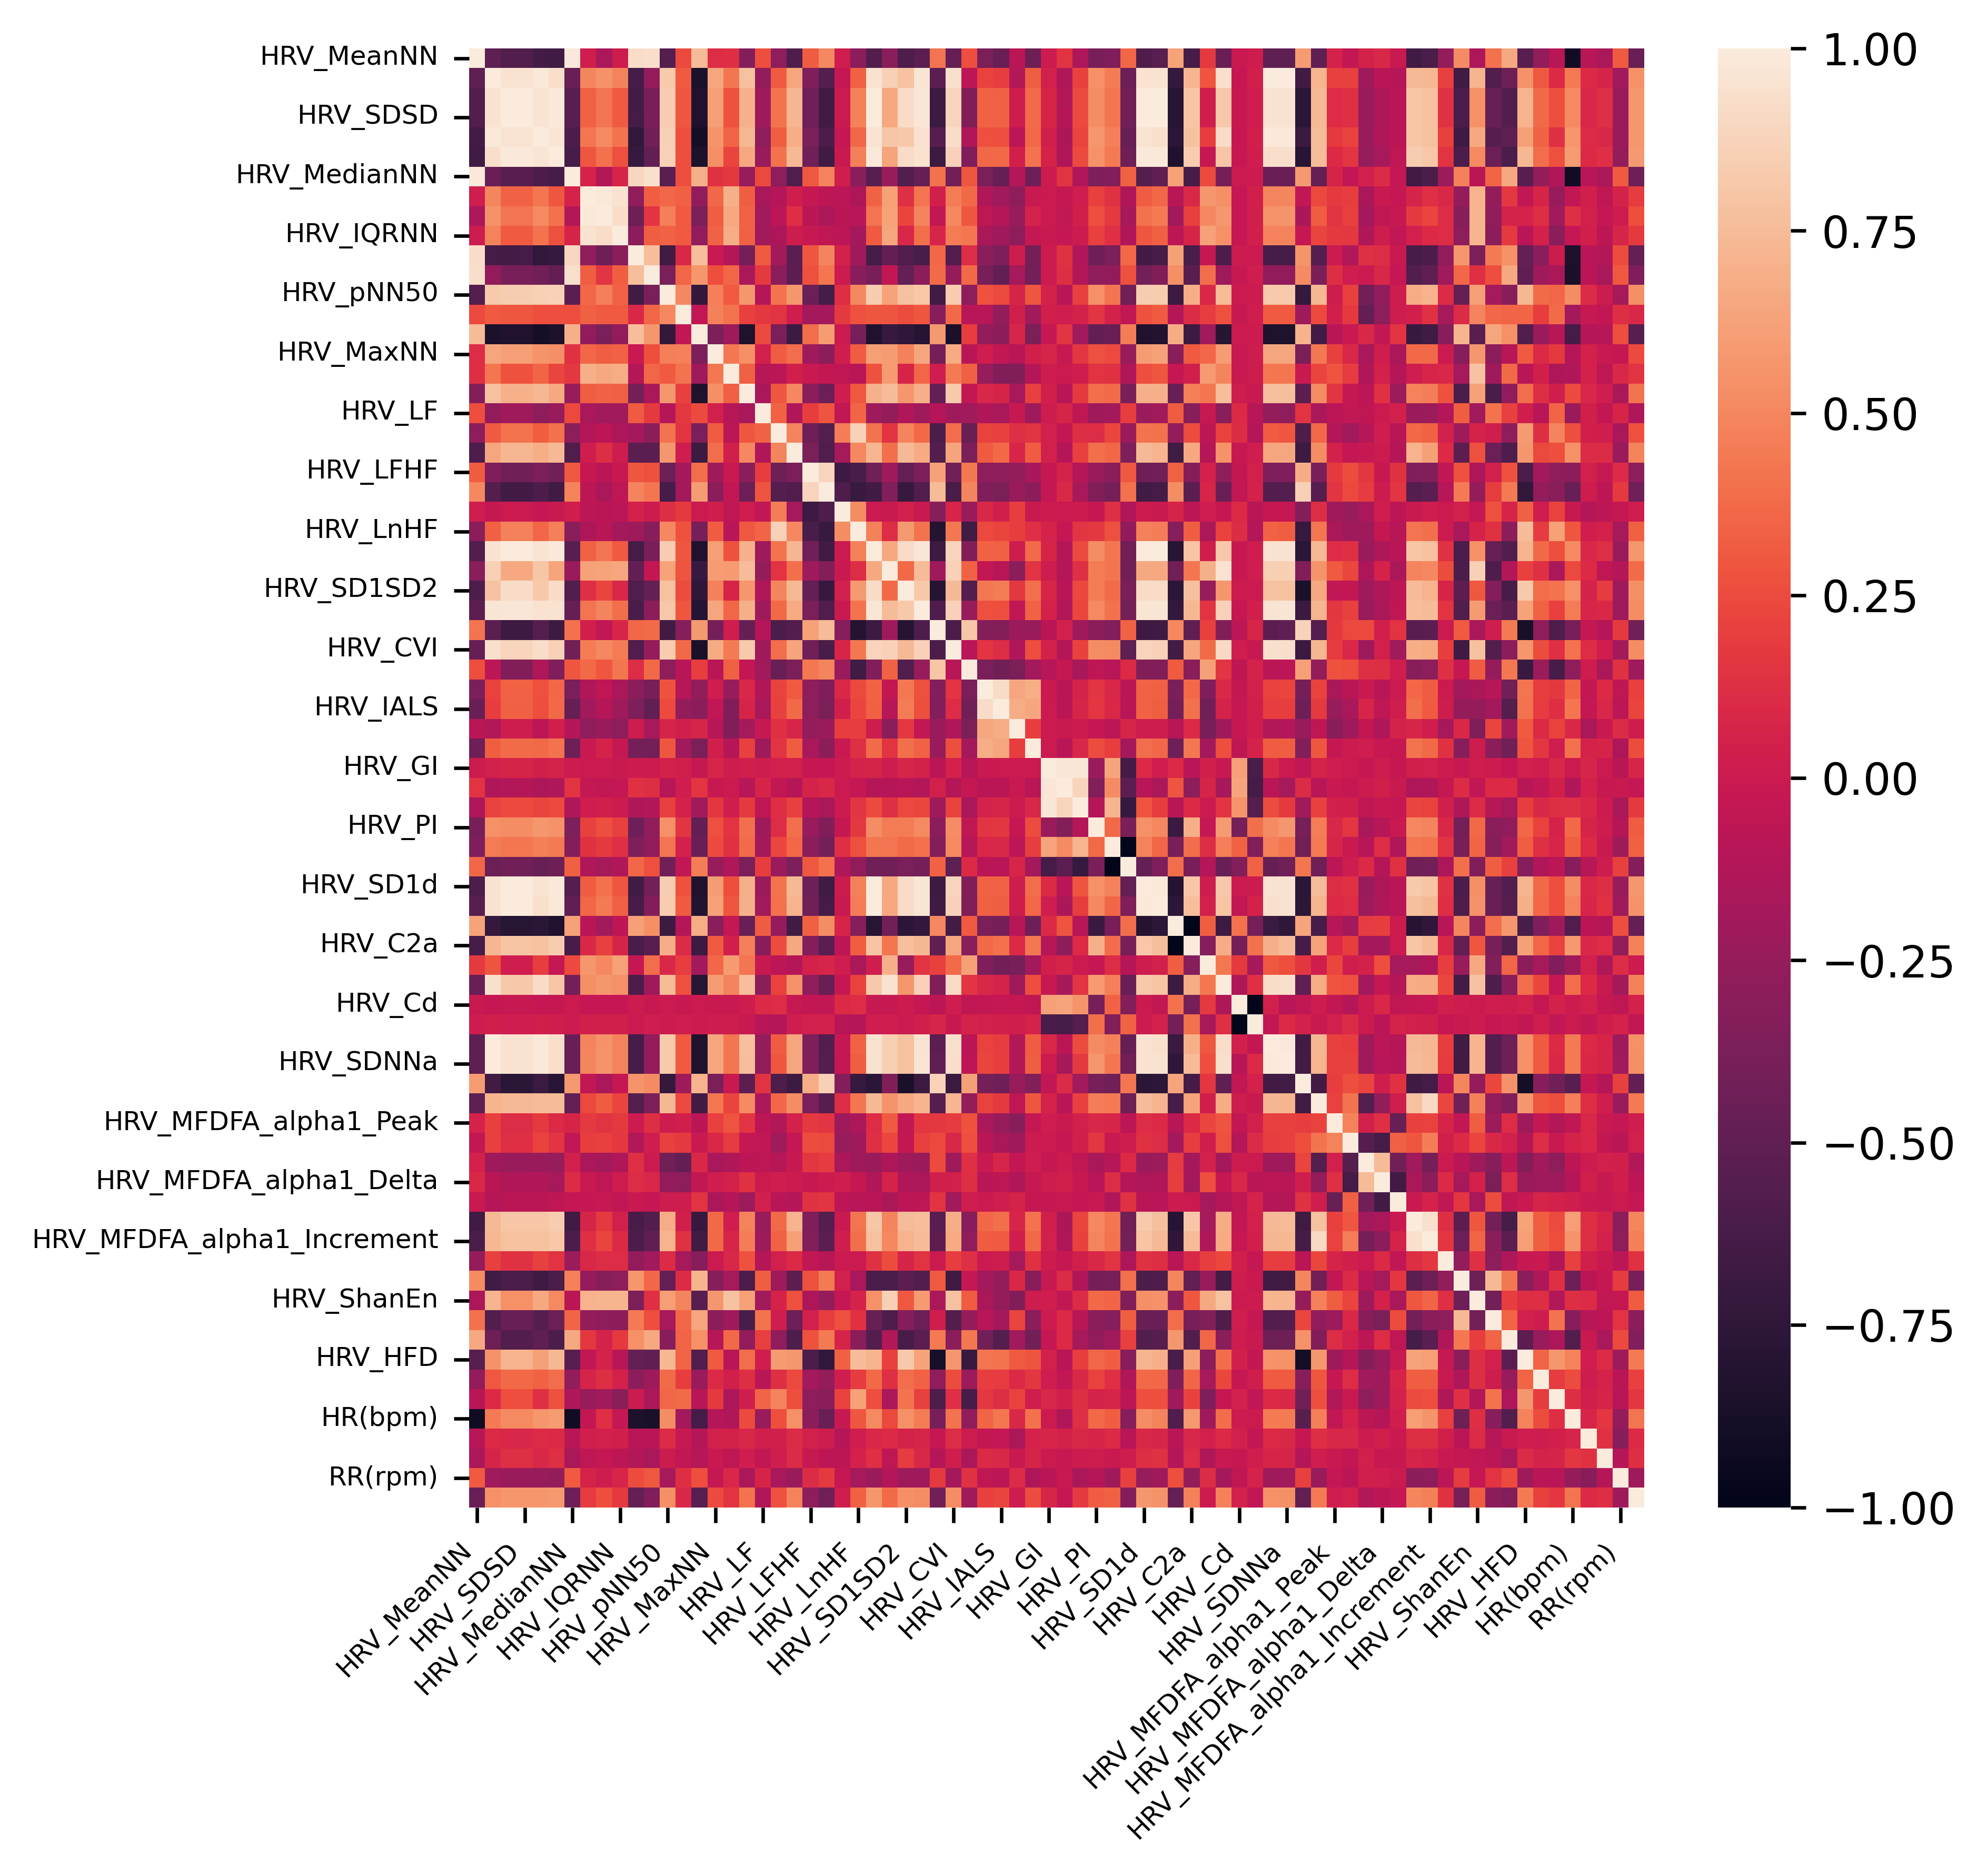

In [52]:
import seaborn as sns
plt.figure(figsize=(6, 6), dpi = 600) 
corr = features_df.corr()
sns.heatmap(corr, vmin=-1.0, vmax=1.0)
plt.tick_params(axis = 'x', labelsize = 6) # x font label size
plt.tick_params(axis = 'y', labelsize = 6) # y font label size
plt.xticks(rotation=45, ha="right")

In [22]:
corr2 = features_df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
display(upper)

C:\Users\petru\AppData\Local\Temp\ipykernel_21400\1859825236.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,...,HRV_FuzzyEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,HR(bpm),SpO2(%),PI(%),RR(rpm),PVCs(/min)
HRV_MeanNN,NaN,-0.512883,-0.574428,-0.573731,-0.644053,-0.661615,0.988618,0.016511,-0.157909,0.011361,...,0.400313,0.650519,-0.540191,-0.264652,-0.092587,-0.912423,-0.097353,-0.159452,0.308828,-0.459224
HRV_SDNN,NaN,NaN,0.951597,0.951593,0.982898,0.934799,-0.459547,0.494414,0.554639,0.483612,...,-0.571899,-0.437793,0.550281,0.304422,0.097222,0.439666,0.095543,0.066038,-0.200831,0.539239
HRV_RMSSD,NaN,NaN,NaN,0.999999,0.958169,0.990192,-0.538279,0.336268,0.419685,0.306942,...,-0.465074,-0.569289,0.710066,0.369229,0.263937,0.512245,0.085168,0.125363,-0.231096,0.566483
HRV_SDSD,NaN,NaN,NaN,NaN,0.957995,0.990051,-0.537556,0.336507,0.419764,0.307158,...,-0.464997,-0.569006,0.709891,0.369143,0.263949,0.511607,0.085069,0.125327,-0.230877,0.566332
HRV_CVNN,NaN,NaN,NaN,NaN,NaN,0.966006,-0.598426,0.423404,0.515583,0.413407,...,-0.547269,-0.510437,0.611233,0.338671,0.130587,0.569358,0.106627,0.083415,-0.237196,0.566211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HR(bpm),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.076902,0.158024,-0.255077,0.417688
SpO2(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.133669,-0.312721,0.096567
PI(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.107809,0.117505
RR(rpm),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.218240


In [39]:
#remove highly correlated features
def remove_collinear_features(x, threshold):

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    corr_matrix = np.abs(corr_matrix)
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

In [44]:
trunc_df = remove_collinear_features(features_df, 0.75)

Removed Columns {'HRV_CVNN', 'HRV_S', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_MinNN', 'HRV_DFA_alpha1', 'HRV_IALS', 'HRV_MFDFA_alpha1_Increment', 'HRV_LnHF', 'HRV_pNN50', 'HRV_SD1d', 'HRV_SI', 'HRV_SDNNa', 'HRV_SD2a', 'HRV_AI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_SD1', 'HRV_SDNNd', 'HRV_C2d', 'HRV_C1a', 'HRV_CVSD', 'HRV_SDSD', 'HRV_HFD', 'HRV_C2a', 'HRV_RMSSD', 'HRV_CSI', 'HRV_Ca', 'HR(bpm)', 'HRV_SD1a', 'HRV_LFn', 'HRV_MedianNN', 'HRV_SD1SD2', 'HRV_MFDFA_alpha1_Width', 'HRV_MFDFA_alpha1_Fluctuation', 'HRV_SD2', 'HRV_TINN', 'HRV_ShanEn', 'HRV_IQRNN', 'HRV_MCVNN'}


In [45]:
display(trunc_df)

,HRV_MeanNN,HRV_SDNN,HRV_MadNN,HRV_pNN20,HRV_MaxNN,HRV_HTI,HRV_LF,HRV_HF,HRV_VHF,HRV_LFHF,...,HRV_ApEn,HRV_SampEn,HRV_FuzzyEn,HRV_CD,HRV_KFD,HRV_LZC,SpO2(%),PI(%),RR(rpm),PVCs(/min)
0,1006.991525,93.087347,55.59750,72.881356,1237.5,7.375000,0.009418,0.135745,0.004593,0.069379,...,0.600961,1.226446,1.013209,1.668837,1.751411,0.997058,93.0,6.10,19.0,4.0
1,1016.101695,78.888113,55.59750,74.576271,1312.5,7.375000,0.009674,0.135260,0.004610,0.071518,...,0.677217,1.265666,1.062335,1.840347,2.014739,1.196470,93.0,6.10,19.0,4.0
2,1012.500000,69.403244,55.59750,72.881356,1237.5,7.375000,0.008268,0.131775,0.004776,0.062746,...,0.676797,1.283346,1.151016,1.881789,2.471393,1.096764,93.0,6.09,19.0,4.0
3,1005.720339,91.601003,55.59750,72.881356,1237.5,7.375000,0.009853,0.127458,0.004376,0.077302,...,0.652896,1.283346,1.026167,1.637781,2.309881,0.997058,93.0,6.08,19.0,4.0
4,1013.559322,103.580515,55.59750,72.881356,1387.5,7.375000,0.007934,0.117931,0.004552,0.067273,...,0.652896,1.283346,0.952391,1.273636,2.366372,1.096764,94.0,6.08,19.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32293,1029.094828,58.414164,37.06500,58.620690,1237.5,4.833333,0.057752,0.142333,0.003597,0.405755,...,0.175999,1.791759,1.175964,1.838873,2.397446,1.312996,95.0,4.79,20.0,0.0
32294,1019.612069,96.430597,37.06500,58.620690,1237.5,5.272727,0.021320,0.035529,0.001482,0.600061,...,0.647959,1.172040,0.849630,1.363747,1.707553,1.211996,95.0,4.66,19.0,0.0
32295,1026.077586,74.386544,37.06500,58.620690,1287.5,5.272727,0.054572,0.143348,0.004065,0.380699,...,0.613675,1.146468,1.010533,1.703348,2.488483,1.211996,95.0,4.53,19.0,0.0
32296,1027.118644,74.174790,37.06500,59.322034,1287.5,5.363636,0.049580,0.132580,0.004867,0.373962,...,0.603282,1.146468,1.012513,1.712671,2.540117,1.196470,95.0,4.41,19.0,0.0


(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5, 30.5, 32.5]),
 [Text(0.5, 0, 'HRV_MeanNN'),
  Text(2.5, 0, 'HRV_MadNN'),
  Text(4.5, 0, 'HRV_MaxNN'),
  Text(6.5, 0, 'HRV_LF'),
  Text(8.5, 0, 'HRV_VHF'),
  Text(10.5, 0, 'HRV_HFn'),
  Text(12.5, 0, 'HRV_PSS'),
  Text(14.5, 0, 'HRV_GI'),
  Text(16.5, 0, 'HRV_C1d'),
  Text(18.5, 0, 'HRV_Cd'),
  Text(20.5, 0, 'HRV_MFDFA_alpha1_Mean'),
  Text(22.5, 0, 'HRV_MFDFA_alpha1_Delta'),
  Text(24.5, 0, 'HRV_ApEn'),
  Text(26.5, 0, 'HRV_FuzzyEn'),
  Text(28.5, 0, 'HRV_KFD'),
  Text(30.5, 0, 'SpO2(%)'),
  Text(32.5, 0, 'RR(rpm)')])

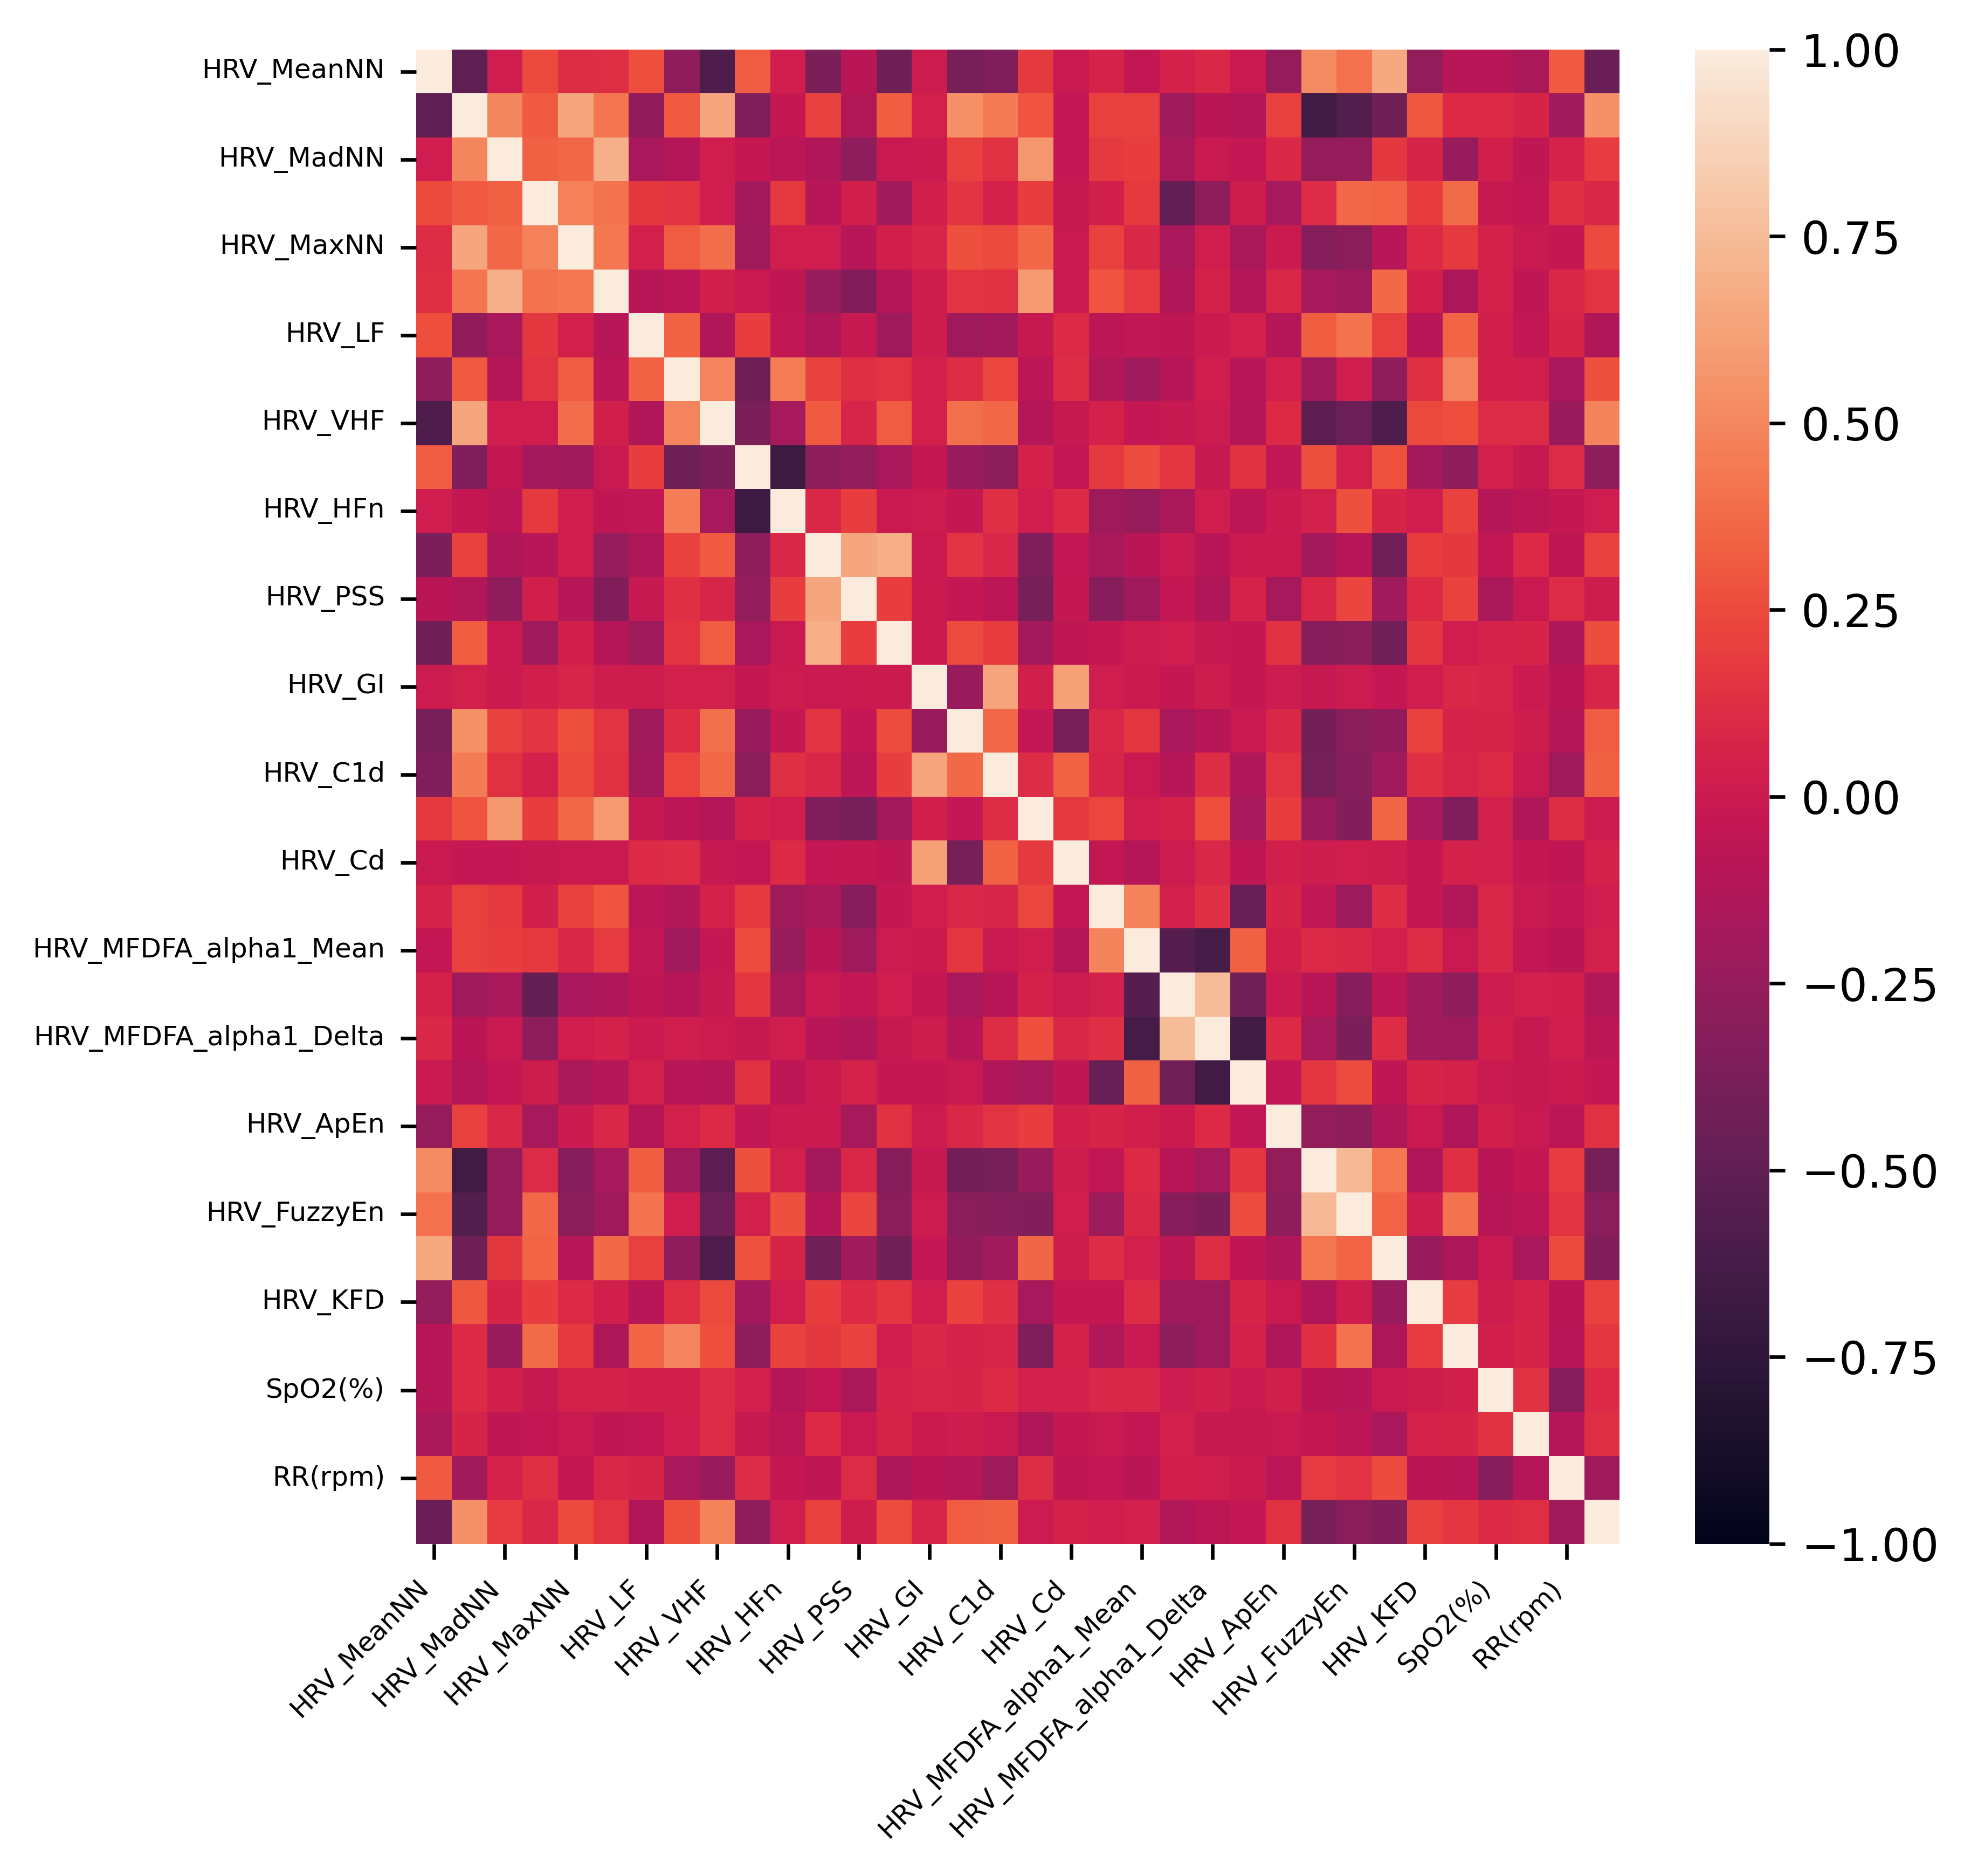

In [51]:
plt.figure(figsize=(6, 6), dpi = 600) 
corr = trunc_df.corr()
sns.heatmap(corr, vmin=-1.0, vmax=1.0)
plt.tick_params(axis = 'x', labelsize = 6) # x font label size
plt.tick_params(axis = 'y', labelsize = 6) # y font label size
plt.xticks(rotation=45, ha="right")


In [54]:
label_df = pd.DataFrame(data = label_data, columns =['event'])

In [55]:
final_df = pd.concat([trunc_df, label_df], axis=1)
display(final_df)

,HRV_MeanNN,HRV_SDNN,HRV_MadNN,HRV_pNN20,HRV_MaxNN,HRV_HTI,HRV_LF,HRV_HF,HRV_VHF,HRV_LFHF,...,HRV_SampEn,HRV_FuzzyEn,HRV_CD,HRV_KFD,HRV_LZC,SpO2(%),PI(%),RR(rpm),PVCs(/min),event
0,1006.991525,93.087347,55.59750,72.881356,1237.5,7.375000,0.009418,0.135745,0.004593,0.069379,...,1.226446,1.013209,1.668837,1.751411,0.997058,93.0,6.10,19.0,4.0,0
1,1016.101695,78.888113,55.59750,74.576271,1312.5,7.375000,0.009674,0.135260,0.004610,0.071518,...,1.265666,1.062335,1.840347,2.014739,1.196470,93.0,6.10,19.0,4.0,0
2,1012.500000,69.403244,55.59750,72.881356,1237.5,7.375000,0.008268,0.131775,0.004776,0.062746,...,1.283346,1.151016,1.881789,2.471393,1.096764,93.0,6.09,19.0,4.0,0
3,1005.720339,91.601003,55.59750,72.881356,1237.5,7.375000,0.009853,0.127458,0.004376,0.077302,...,1.283346,1.026167,1.637781,2.309881,0.997058,93.0,6.08,19.0,4.0,0
4,1013.559322,103.580515,55.59750,72.881356,1387.5,7.375000,0.007934,0.117931,0.004552,0.067273,...,1.283346,0.952391,1.273636,2.366372,1.096764,94.0,6.08,19.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32293,1029.094828,58.414164,37.06500,58.620690,1237.5,4.833333,0.057752,0.142333,0.003597,0.405755,...,1.791759,1.175964,1.838873,2.397446,1.312996,95.0,4.79,20.0,0.0,0
32294,1019.612069,96.430597,37.06500,58.620690,1237.5,5.272727,0.021320,0.035529,0.001482,0.600061,...,1.172040,0.849630,1.363747,1.707553,1.211996,95.0,4.66,19.0,0.0,0
32295,1026.077586,74.386544,37.06500,58.620690,1287.5,5.272727,0.054572,0.143348,0.004065,0.380699,...,1.146468,1.010533,1.703348,2.488483,1.211996,95.0,4.53,19.0,0.0,0
32296,1027.118644,74.174790,37.06500,59.322034,1287.5,5.363636,0.049580,0.132580,0.004867,0.373962,...,1.146468,1.012513,1.712671,2.540117,1.196470,95.0,4.41,19.0,0.0,0


Processed features:   0%|          | 0/5 [00:00<?, ?it/s]

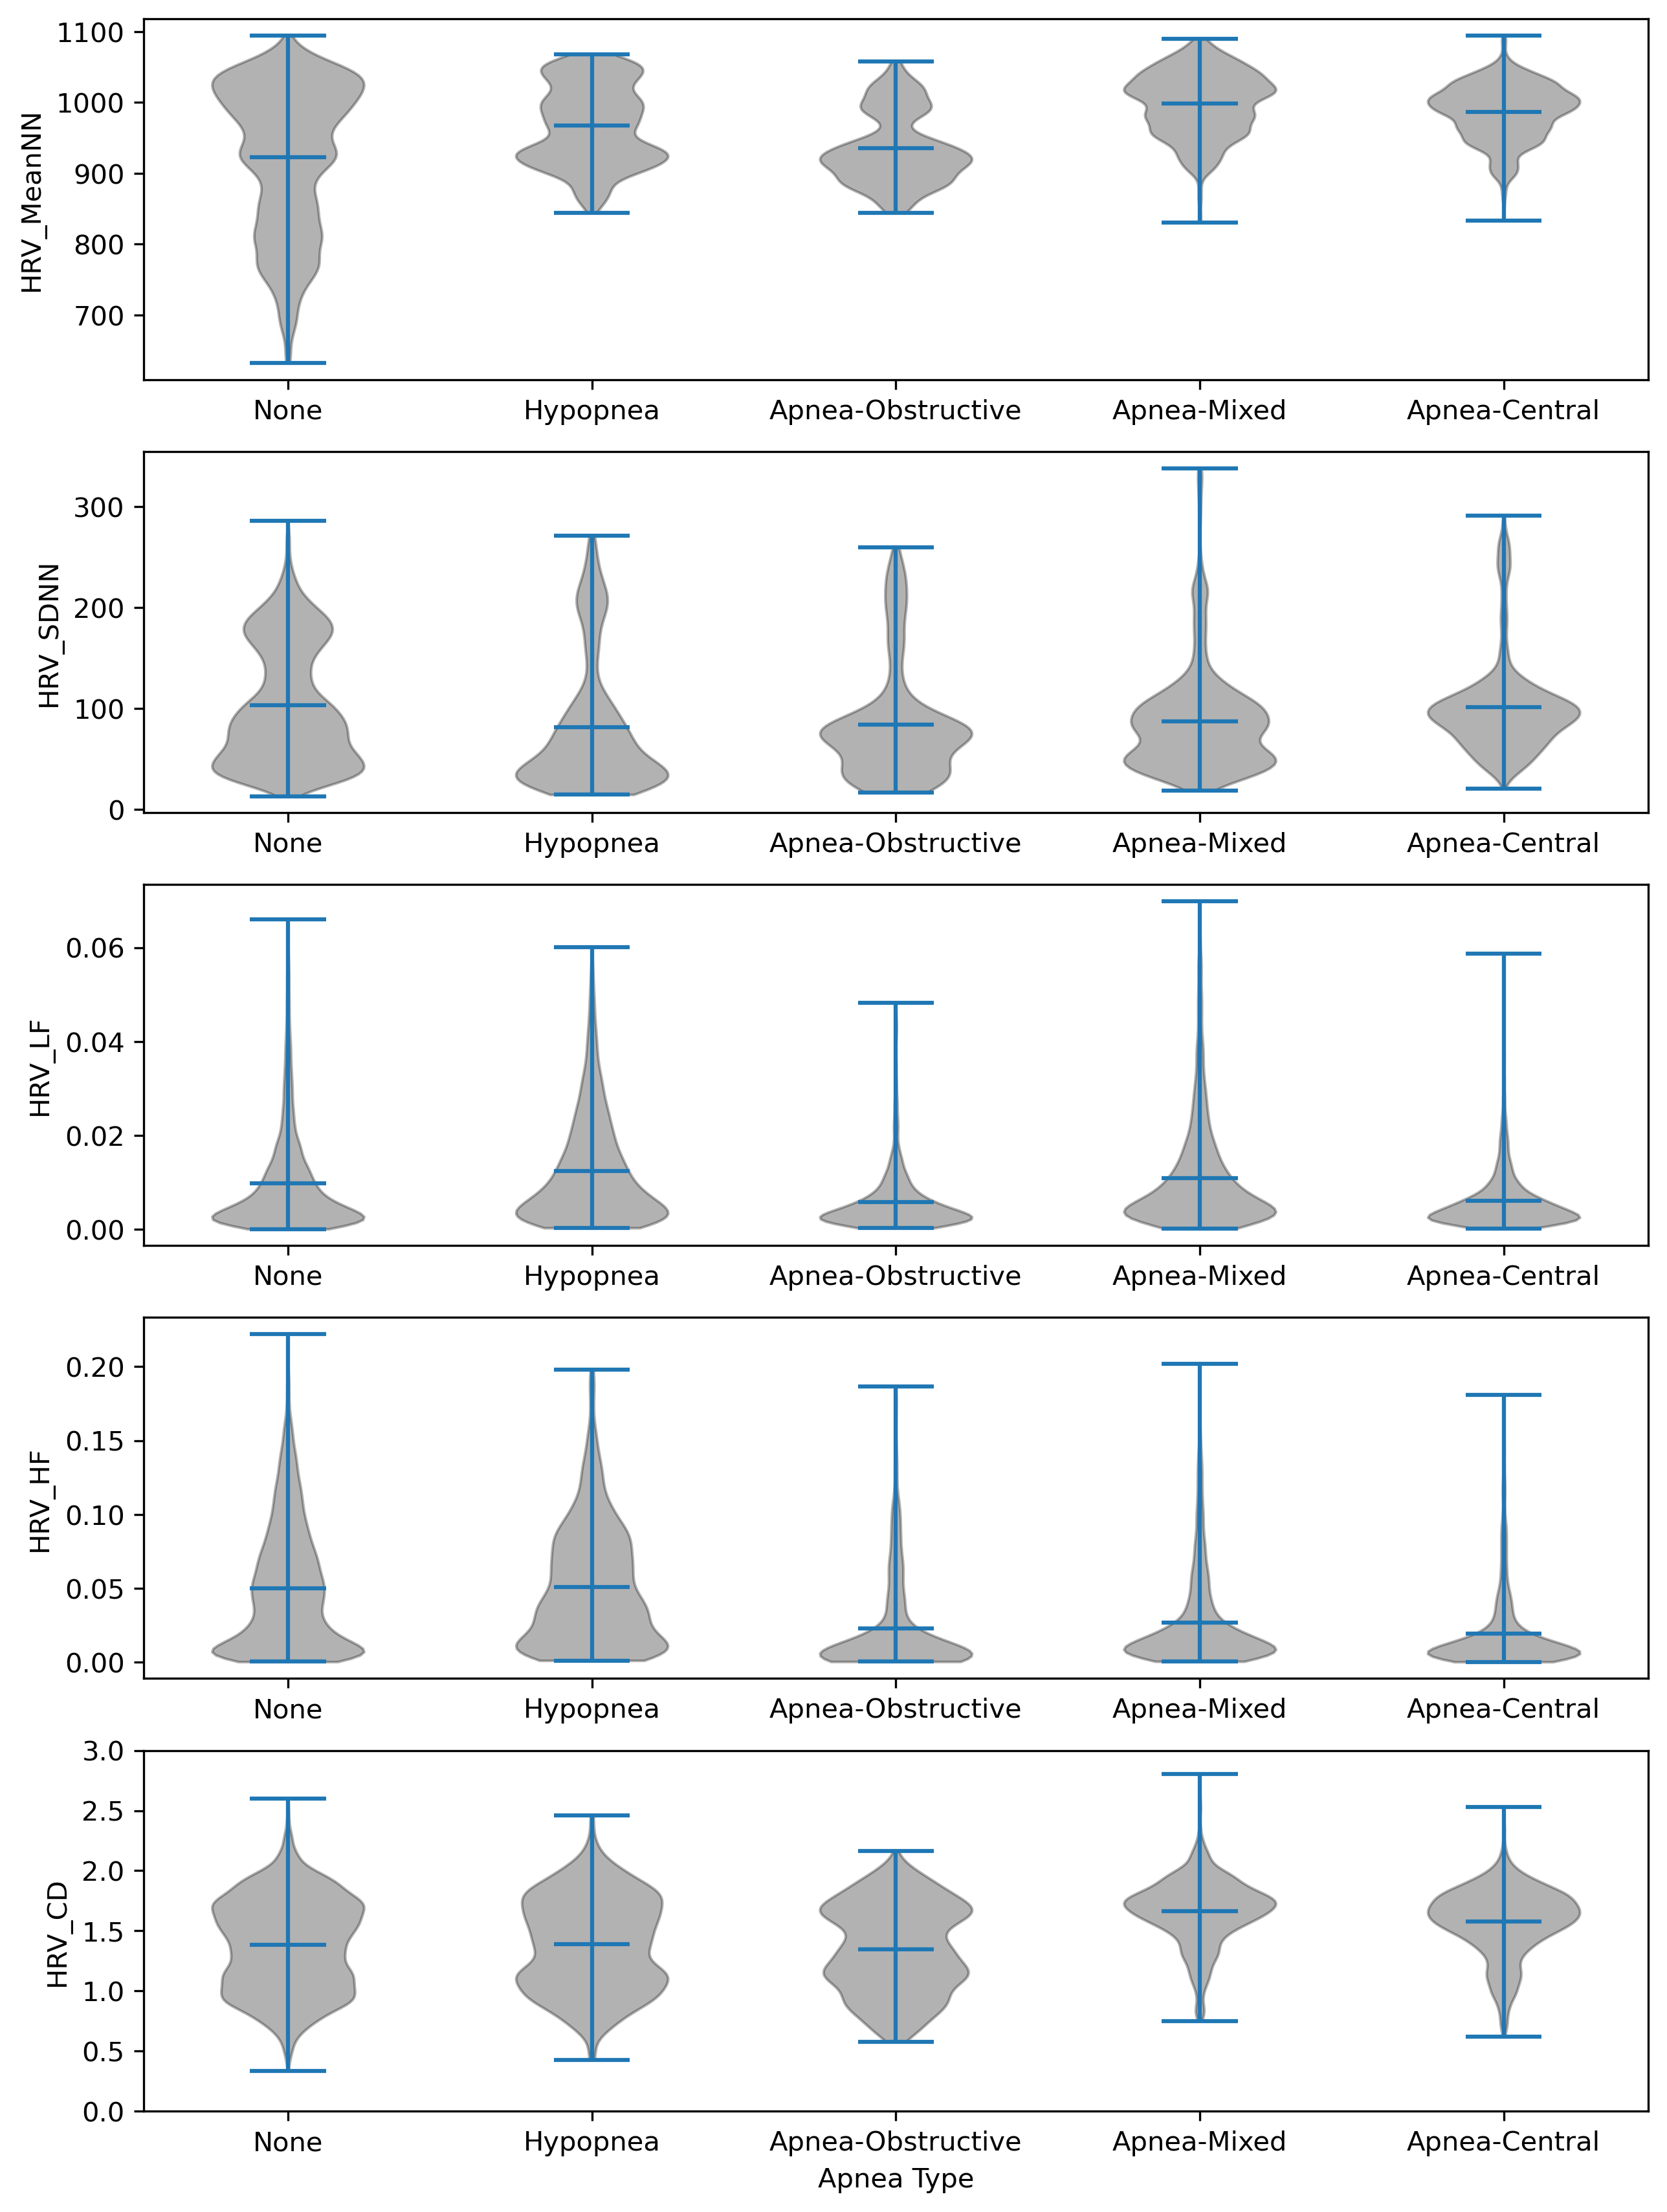

In [81]:
plt.figure(figsize=(10, 14), dpi=300)
plt.title('Violin Plots of Cardiac Features over Apnea Types')
pbar = tqdm(desc="Processed features", total=5)
for i, column in enumerate(['HRV_MeanNN', 'HRV_SDNN', 'HRV_LF', 'HRV_HF', 'HRV_CD']):
    plt.subplot(5, 1, i+1)
    plot_data = []
    for apn in np.unique(final_df.event):
        temp = final_df[final_df.event == apn][column]
        plot_data.append([x for x in list(temp.values) if not np.isnan(x)])

    violin_parts = plt.violinplot(plot_data, showextrema = True, showmeans=True)

    for pc in violin_parts['bodies']:
        pc.set_facecolor('black')
        pc.set_edgecolor('black')   


    if i == 4:
        plt.ylim(top=3)
        plt.ylim(bottom=0)       
        plt.xlabel("Apnea Type")
    plt.ylabel(column)
    plt.xticks([1,2,3,4,5], ['None', 'Hypopnea', 'Apnea-Obstructive', 'Apnea-Mixed', 'Apnea-Central'])
    pbar.update(1)
pbar.close()
plt.show() 

In [ ]:
plt.figure(figsize=(10, 10), dpi=300)